In [1]:
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
from shapely.geometry import Point
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from pandas import DataFrame, Series
from matplotlib.pyplot import Axes
from osgeo import gdal

## Data wrangling

- read field sampling data
- remove unwanted columns from the field data
- rename columns to meaningful names
- created smaller database with just average results

set up lookup tables and helper functions

In [2]:
# superset of column names
all_cols = {
    'globalid': ['id', 'Unique Site ID'],
    'Site': ['site', 'Site No'],
    'plot': ['plot', 'Plot No'], 
    'Date': ['date', 'Date'], 
    'Name': ['name', 'Assessor Name'], 
    'Fuel': ['veg_type', 'Vegetation Class'],
    'FireHistor': ['fire_hist', 'Time since Fire (y)'], 
    'latitude': ['lat', 'Latitude (°)'], 
    'longitude': ['lon', 'Longitude (°)'],
    'horaccmete': ['loc_accuracy', 'Location accuracy (m)'],
    'FuelDepth1': ['litter_d_1', 'Litter Depth: Sample 1 (mm)'],
    'Cover1': ['litter_state_1', 'Litter State: Sample 1 (presence/absence)'], 
    'NearSurfac': ['ns_h_1', 'Near surface fuel height: Sample 1 (m)'],
    'NearSurf_1': ['ns_state_1', 'Near surface fuel state: Sample 1 (absent/alive/dead)'],
    'Elevated1': ['elev_h_1', 'Elevated fuel height: Sample 1 (m)'],
    'ElevatedCo': ['elev_state_1', 'Elevated fuel state: Sample 1 (absent/alive/dead)'],
    'CanopyHeig': ['canopy_h_1', 'Canopy height: Sample 1 (m)'],
    'CanopyCove': ['canopy_cov_1', 'Canopy cover: Sample 1 (%)'],
    'FuelDepth2': ['litter_d_2', 'Litter Depth: Sample 2 (mm)'], 
    'Cover2': ['litter_state_2', 'Litter State: Sample 2 (presence/absence)'],
    'NearSurf_2': ['ns_h_2', 'Near surface fuel height: Sample 2 (m)'], 
    'NearSurf_3': ['ns_state_2', 'Near surface fuel state: Sample 2 (absent/alive/dead)'],
    'Elevated2': ['elev_h_2', 'Elevated fuel height: Sample 2 (m)'],
    'Elevated_1': ['elev_state_2', 'Elevated fuel state: Sample 2 (absent/alive/dead)'],
    'FuelDepth3': ['litter_d_3', 'Litter Depth: Sample 3 (mm)'],
    'Cover3': ['litter_state_3', 'Litter State: Sample 3 (presence/absence)'],
    'NearSurf_4': ['ns_h_3', 'Near surface fuel height: Sample 3 (m)'],
    'NearSurf_5': ['ns_state_3', 'Near surface fuel state: Sample 3 (absent/alive/dead)'],
    'Elevated3': ['elev_h_3', 'Elevated fuel height: Sample 3 (m)'],
    'Elevated_2': ['elev_state_3', 'Elevated fuel state: Sample 3 (absent/alive/dead)'],
    'CanopyHe_1': ['canopy_h_3', 'Canopy height: Sample 3 (m)'],
    'CanopyCo_1': ['canopy_cov_3', 'Canopy cover: Sample 3 (%)'],
    'FuelDepth4': ['litter_d_4', 'Litter Depth: Sample 4 (mm)'],
    'Cover4': ['litter_state_4', 'Litter State: Sample 4 (presence/absence)'],
    'NearSurf_6': ['ns_h_4', 'Near surface fuel height: Sample 4 (m)'],
    'NearSurf_7': ['ns_state_4', 'Near surface fuel state: Sample 4 (absent/alive/dead)'],
    'Elevated4': ['elev_h_4', 'Elevated fuel height: Sample 4 (m)'],
    'Elevated_3': ['elev_state_4', 'Elevated fuel state: Sample 4 (absent/alive/dead)'],
    'FuelDepth5': ['litter_d_5', 'Litter Depth: Sample 5 (mm)'],
    'Cover5': ['litter_state_5', 'Litter State: Sample 5 (presence/absence)'],
    'NearSurf_8': ['ns_h_5', 'Near surface fuel height: Sample 5 (m)'],
    'NearSurf_9': ['ns_state_5', 'Near surface fuel state: Sample 5 (absent/alive/dead)'],
    'Elevated5': ['elev_h_5', 'Elevated fuel height: Sample 5 (m)'],
    'Elevated_4': ['elev_state_5', 'Elevated fuel state: Sample 5 (absent/alive/dead)'],
    'CanopyHe_2': ['canopy_h_5', 'Canopy height: Sample 5 (m)'],
    'CanopyCo_2': ['canopy_cov_5', 'Canopy cover: Sample 5 (%)'],
    'FuelDepth6': ['litter_d_6', 'Litter Depth: Sample 6 (mm)'],
    'Cover6': ['litter_state_6', 'Litter State: Sample 6 (presence/absence)'],
    'NearSur_10': ['ns_h_6', 'Near surface fuel height: Sample 6 (m)'],
    'NearSur_11': ['ns_state_6', 'Near surface fuel state: Sample 6 (absent/alive/dead)'],
    'Elevated6': ['elev_h_6', 'Elevated fuel height: Sample 6 (m)'],
    'Elevated_5':['elev_state_6', 'Elevated fuel state: Sample 6 (absent/alive/dead)'],
    'FuelDepth7': ['litter_d_7', 'Litter Depth: Sample 7 (mm)'],
    'Cover7': ['litter_state_7', 'Litter State: Sample 7 (presence/absence)'],
    'NearSur_12': ['ns_h_7', 'Near surface fuel height: Sample 7 (m)'],
    'NearSur_13': ['ns_state_7', 'Near surface fuel state: Sample 7 (absent/alive/dead)'],
    'Elevated7': ['elev_h_7', 'Elevated fuel height: Sample 7 (m)'],
    'Elevated_6': ['elev_state_7', 'Elevated fuel state: Sample 7 (absent/alive/dead)'],
    'CanopyHe_3': ['canopy_h_7', 'Canopy height: Sample 7 (m)'],
    'CanopyCo_3': ['canopy_cov_7', 'Canopy cover: Sample 7 (%)'],
    'FuelDepth8': ['litter_d_8', 'Litter Depth: Sample 8 (mm)'], 
    'Cover8': ['litter_state_8', 'Litter State: Sample 8 (presence/absence)'],
    'NearSur_14': ['ns_h_8', 'Near surface fuel height: Sample 8 (m)'],
    'NearSur_15': ['ns_state_8', 'Near surface fuel state: Sample 8 (absent/alive/dead)'],
    'Elevated8': ['elev_h_8', 'Elevated fuel height: Sample 8 (m)'],
    'Elevated_7': ['elev_state_8', 'Elevated fuel state: Sample 8 (absent/alive/dead)'],
    'FuelDepth9': ['litter_d_9', 'Litter Depth: Sample 9 (mm)'],
    'Cover9': ['litter_state_9', 'Litter State: Sample 9 (presence/absence)'],
    'NearSur_16': ['ns_h_9', 'Near surface fuel height: Sample 9 (m)'],
    'NearSur_17': ['ns_state_9', 'Near surface fuel state: Sample 9 (absent/alive/dead)'],
    'Elevated9': ['elev_h_9', 'Elevated fuel height: Sample 9 (m)'],
    'Elevated_8': ['elev_state_9', 'Elevated fuel state: Sample 9 (absent/alive/dead)'],
    'CanopyHe_4': ['canopy_h_9', 'Canopy height: Sample 9 (m)'],
    'CanopyCo_4': ['canopy_cov_9', 'Canopy cover: Sample 9 (%)'],
    'FuelDept_1': ['litter_d_10', 'Litter Depth: Sample 10 (mm)'],
    'Cover10': ['litter_state_10', 'Litter State: Sample 10 (presence/absence)'],
    'NearSur_18': ['ns_h_10', 'Near surface fuel height: Sample 10 (m)'],
    'NearSur_19': ['ns_state_10', 'Near surface fuel state: Sample 10 (absent/alive/dead)'],
    'Elevated10': ['elev_h_10', 'Elevated fuel height: Sample 10 (m)'],
    'Elevated_9': ['elev_state_10', 'Elevated fuel state: Sample 10 (absent/alive/dead)'],
    'AverageFue': ['litter_d_m', 'Mean litter depth (mm)'],
    'AverageSur': ['litter_state_count', 'Litter cover P/A count (/10)'],
    'AveragePer': ['litter_cov', 'Litter cover (%)'],
    'FuelLoad': ['litter_load', 'Litter fuel load (t/ha)'],
    'Fuel_Hazar': ['s_fhr', 'Surface fuel hazard rating'], 
    'averageNSh': ['ns_h_m', 'Mean near surface height (m)'], 
    'averageNSc': ['ns_state_count', 'Near Surface P/A count (/10)'], 
    'averageN_1': ['ns_cov', 'Near surface cover (%)'], 
    'averageNSd': ['ns_dead_count', 'Near surface dead count'], 
    'percentage': ['ns_dead_%', 'Near surface dead as percentage of near surface present'], 
    'nearsur_20': ['_ns_fhr', 'Near surface Fuel Hazard Rating'], # repeat?
    'Near_Surfa': ['ns_fhr', 'Near surface Fuel Hazard Rating'], 
    'nearsur_21': ['ns_load', 'Near surface fuel load (t/ha)'], 
    'combined': ['s&ns_fhr', 'Combined surface and near surface Fuel Hazard Rating'], 
    'averageele': ['elev_h_m', 'Mean elevated height (m)'], 
    'averagee_1': ['elev_state_count', 'Elevated P/A count (/10)'], 
    'averagee_2': ['elev_cov', 'elevated cover (%)'], 
    'averagee_3': ['elev_dead_count', 'Elevated dead count'],
    'elevatedpe': ['elev_dead_%', 'elevated dead as percentage of elevated present'], 
    'elevated_f': ['_elev_fhr', 'Elevated Fuel Hazard Rating'], # repeat?
    'elevated_h': ['elev_fhr', 'Elevated Fuel Hazard Rating'], 
    'elevate_10': ['elev_load', 'Elevated fuel load (t/ha)'], 
    'bark_type': ['bark_type', 'Bark type'], 
    'bark_fuel': ['bark_haz&type', 'Bark hazard rating and type'], 
    'bark_hazar': ['bark_haz', 'Bark hazard rating'], 
    'bark_fuell': ['bark_load', 'Bark fuel load (t/ha)'], 
    'height_ave': ['canopy_h_m', 'Mean canopy height (m)'], 
    'cannopy_av':['canopy_cov_m', 'Mean canopy cover (%)'], 
    'plotgood': ['representative', 'Plot is representative of area (Y/N)'], 
    'comments': ['comments', 'Comments'],
    'geometry': ['geometry', 'Shapefile geometry'],
}

# column names and descriptions
labels = {
    'afo_cc': 'AFO Crown Cover %',
    'afo_lfd': 'AFO Ladder Fuel Density',
    'afo_ch': 'AFO Canopy Height (m)',
    'afo_cbh': 'AFO Canopy Base Height (m)',
    'afo_litter': 'AFO litter fuel load (t/ha)', 
    'afo_surface': 'AFO surface fuel load (t/ha)', 
    'afo_elevated': 'AFO elevated fuel  load (t/ha)', 
    'afo_bark': 'AFO bark fuel load (t/ha)'
}

#smaller working set of data - extraneous columns removed
subset = [
    'id', 'site', 'plot', 'veg_type', 'fire_hist', 'loc_accuracy', 
    'litter_d_m', 'litter_cov', 'litter_load', 's_fhr', 
    'ns_h_m', 'ns_cov', 'ns_fhr', 'ns_load', 
    's&ns_fhr', 
    'elev_h_m', 'elev_cov', 'elev_fhr', 'elev_load', 
    'bark_type', 'bark_haz', 'bark_load', 
    'canopy_h_m', 'canopy_cov_m', 
    'representative', 'comments', 'geometry'
]

In [3]:
# helper functions
def read_afo(paths: dict, coord_df: GeoDataFrame, index: int = None, offset: int = 0) -> Series:
    """samples single and multiband AFO geotiffs

    Args:
        paths (dict): region names and relative path to geotiffs
        coord_df (GeoDataFrame): gdf containing sample coordinates as `geometry`
        index (int, optional): for multiband data the index of the band to sample
        offset (int, optional): generates random offsets to test robustness of data
            sampling to location. Maximum offset in x or y is `offset`

    Returns:
        Series: sampled data
    """

    coord_df = coord_df[['geometry']]
    for loc, path in paths.items():
        with rasterio.open(path, 'r') as src:
            print(f'Input CRS is: {src.crs}')
            coord_df = coord_df.to_crs(src.crs)
            site_coords = [
                (x,y) for x,y in zip(
                    coord_df['geometry'].x - offset, coord_df['geometry'].y
                )
            ]
            coord_df[loc] = -9999
            if index is None:
                coord_df[loc] = [x for x in src.sample(site_coords)]
            else:
                coord_df[loc] = [x[index] for x in src.sample(site_coords)]
    
    return coord_df[paths.keys()].max(axis=1)

def read_rfs(path: str, coord_df: GeoDataFrame) -> Series:
    """reads RFS corporate data in geotiff form

    Args:
        path (str): path to the geotiff file
        coord_df (GeoDataFrame): gdf containing sample coordinates as `geometry`

    Returns:
        Series: sampled data
    """
    coord_df = coord_df[['geometry']]
    with rasterio.open(path, 'r') as src:
        print(f'Input CRS is: {src.crs}')
        coord_df = coord_df.to_crs(src.crs)
        site_coords = [
            (x,y) for x,y in zip(coord_df['geometry'].x, coord_df['geometry'].y)
        ]
        coord_df['sample_data'] = [x[0] for x in src.sample(site_coords)]
    return coord_df['sample_data']

def reg_plot(x: str, y: str, df: DataFrame, hue: str=None) -> Axes:
    """Regression plot with stats. Points coloured by `hue`

    Args:
        x (str): df column name for x values
        y (str): df column name for y values
        df (DataFrame):
        hue (str): df column name to use to colour the values. Defaults to `None` 
    """
    _df = df[[x, y]].dropna()
    slope, intercept, r_value, p_value, std_err = linregress(_df[x], _df[y])
    print(f'{labels[x]} v {labels[y]}')
    print(f'stats:')
    print(f'pearson r: {r_value:.2f} \t r sq: {r_value**2:.2f} \t p: {p_value:.2f}')
    grid = sns.lmplot(x=x, y=y, data=df, hue=hue, fit_reg=False, height=8, aspect=1.5)
    sns.regplot(x=x, y=y, data=df, scatter=False, ax=grid.axes[0, 0]) 
    grid.axes[0, 0].set(xlabel=labels[x], ylabel=labels[y])
    return grid

def reg_plots(x: str, y: str, df: DataFrame, hue: str=None) -> sns.FacetGrid:
    """creates a series of linear regression with axis labels and calculates
    descriptive statistics.

    Args:
        x (str): df column name for x values
        y (str): df column name for y values
        df (DataFrame):
        hue (str, optional): df column name to define subsets. Defaults to `None`.
    """
    regressions = sns.FacetGrid(df, col=hue, hue=hue, height=5, aspect=1.2, col_wrap=2)
    regressions.map(sns.regplot, x, y)
    regressions.set_ylabels(labels[y])
    regressions.set_xlabels(labels[x])
    
    subsets = set(df[hue])
    for r in subsets:
        _df = df.loc[df[hue]==r]
        _df = _df[[x, y]].dropna()
        if _df.shape[0] > 5: # make sure _df not too small
            slope, intercept, r_value, p_value, std_err = linregress(_df[x], _df[y], )
            print(f'{r} stats:')
            print(f'pearson r: {r_value:.2f} \t r sq: {r_value**2:.2f} \t p: {p_value:.2f}')

    return regressions

def rasters_resample(path_dict: dict, res: float) -> dict:
    """resamples geotiffs to resolution = `res`.

    Args:
        path_dict (dict): dictionary containing path to input geotifs.
        res (float): resolution in projected units of resultant geotiff

    Returns:
        dict: dictionary containing path to input geotifs.
    """
    out_paths = {}
    for key, path in path_dict.items():
        outpath = f'{path.split(".")[0]}_{res}.tif'
        gdal.Translate(
            outpath, path,
            options=f'-of GTiff -tr {res} {res} -r bilinear'
        )
        out_paths[key] = outpath 
    return out_paths

read the site and field sampling geodata

In [4]:
gdf = gpd.read_file('spatial_data/Field_Data/Fuel_Sampling___Version_0_1.shp')
# site_gdf = gpd.read_file('spatial_data/Sample_Points.shp')

rename columns to something meaningful (associated with longer description in dictionary)

In [5]:
rename_dict = {} # used to cut down and rename columns
for key, [field, desc] in all_cols.items():
    rename_dict[key] = field
    labels[field] = desc
gdf = gdf.rename(columns=rename_dict)

the survey app deals poorly with missing data so recalculate means and percentages

In [6]:
quantitative_fields = ['canopy_cov', 'canopy_h', 'elev_h', 'litter_d', 'ns_h']
presence_absence_fields = ['elev_state', 'litter_state', 'ns_state']

for field in quantitative_fields:
    cols = [string for string in list(gdf.columns.values) if field in string]
    gdf[f'{field}_m'] = gdf[cols[:-1]].mean(axis=1)

for field in presence_absence_fields:
    cols = [string for string in list(gdf.columns.values) if field in string]
    gdf[f'{field}_count'] = (
        gdf[gdf[cols[:-1]] == 'alive'].count(axis=1) + 
        gdf[gdf[cols[:-1]] == 'dead'].count(axis=1) + 
        gdf[gdf[cols[:-1]] == 'yes'].count(axis=1)
    )
    prefix=field.split('_')[0]
    gdf[f'{prefix}_cov'] = gdf[f'{field}_count']*10

cut down the number of columns

In [7]:
gdf = gdf[subset]
# sort it just because we can :)
gdf.sort_values(by=['site', 'plot'], inplace=True)
gdf.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,elev_fhr,elev_load,bark_type,bark_haz,bark_load,canopy_h_m,canopy_cov_m,representative,comments,geometry
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5,Moderate,...,None,10,Slab,Low,0,6.8,30.0,yes,None,POINT (151.28407 -33.58385)
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.5,Low,...,High,2,Slab,Low,0,5.2,26.0,None,None,POINT (151.28377 -33.58408)
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,High,2,Slab,Moderate,0,5.0,16.0,yes,None,POINT (151.28358 -33.58432)
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5,Moderate,...,Moderate,0,Slab,Low,0,11.0,60.0,yes,None,POINT (151.04137 -34.16933)
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.5,Low,...,Moderate,0,Slab,Low,0,9.8,26.0,yes,None,POINT (151.04147 -34.16886)


shapefile data are imported as objects so need to convert to data types that can be used for correlation and other analyses

In [8]:
gdf= gdf.replace('BlanK', np.nan) # some missing values

numeric = [
    'litter_d_m', 'litter_cov', 'litter_load', 
    'ns_h_m', 'ns_cov', 'ns_load', 
    'elev_h_m', 'elev_cov', 'elev_load', 
    'bark_load', 
    'canopy_h_m', 'canopy_cov_m', 
]

for col in numeric:
    gdf[col] = pd.to_numeric(gdf[col])
gdf.dtypes

id                  object
site                object
plot                object
veg_type            object
fire_hist           object
loc_accuracy       float64
litter_d_m         float64
litter_cov           int64
litter_load        float64
s_fhr               object
ns_h_m             float64
ns_cov               int64
ns_fhr              object
ns_load            float64
s&ns_fhr            object
elev_h_m           float64
elev_cov             int64
elev_fhr            object
elev_load            int64
bark_type           object
bark_haz            object
bark_load            int64
canopy_h_m         float64
canopy_cov_m       float64
representative      object
comments            object
geometry          geometry
dtype: object

In [9]:
# add region identifiers
gdf['region'] = np.where(
    gdf['site'].str.startswith('EC'), 'central',
        np.where(gdf['site'].str.startswith('P'), 'pilliga', 
            np.where(gdf['site'].str.startswith('SM'),'snowy', 'other')
    )
)
gdf.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,elev_load,bark_type,bark_haz,bark_load,canopy_h_m,canopy_cov_m,representative,comments,geometry,region
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,10,Slab,Low,0,6.8,30.0,yes,None,POINT (151.28407 -33.58385),central
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,2,Slab,Low,0,5.2,26.0,None,None,POINT (151.28377 -33.58408),central
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,2,Slab,Moderate,0,5.0,16.0,yes,None,POINT (151.28358 -33.58432),central
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,0,Slab,Low,0,11.0,60.0,yes,None,POINT (151.04137 -34.16933),central
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,0,Slab,Low,0,9.8,26.0,yes,None,POINT (151.04147 -34.16886),central


## Sample the AFO geotiffs

It seems that all the geotiffs are all projected using the MGA zone 56 crs (EPSG:32756) regardless of what zone they are in but let's check this as we read them.

In [10]:
#crown cover
cc_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_cover-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_cover-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_cover-2021.tif',
}

gdf['afo_cc'] = read_afo(cc_paths, gdf)
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,bark_type,bark_haz,bark_load,canopy_h_m,canopy_cov_m,representative,comments,geometry,region,afo_cc
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,Slab,Low,0,6.8,30.0,yes,None,POINT (151.28407 -33.58385),central,50.941280
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,Slab,Low,0,5.2,26.0,None,None,POINT (151.28377 -33.58408),central,53.012089
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,Slab,Moderate,0,5.0,16.0,yes,None,POINT (151.28358 -33.58432),central,36.591705
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,Slab,Low,0,11.0,60.0,yes,None,POINT (151.04137 -34.16933),central,82.196129
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,Slab,Low,0,9.8,26.0,yes,None,POINT (151.04147 -34.16886),central,73.356422


In [11]:
# ladder fuel density
lfd_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-ladder_fuel_density-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-ladder_fuel_density-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-ladder_fuel_density-2021.tif',
}
gdf['afo_lfd'] = read_afo(lfd_paths, gdf)
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,bark_haz,bark_load,canopy_h_m,canopy_cov_m,representative,comments,geometry,region,afo_cc,afo_lfd
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,Low,0,6.8,30.0,yes,None,POINT (151.28407 -33.58385),central,50.941280,10.934896
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,Low,0,5.2,26.0,None,None,POINT (151.28377 -33.58408),central,53.012089,8.507341
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,Moderate,0,5.0,16.0,yes,None,POINT (151.28358 -33.58432),central,36.591705,15.579016
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,Low,0,11.0,60.0,yes,None,POINT (151.04137 -34.16933),central,82.196129,3.869198
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,Low,0,9.8,26.0,yes,None,POINT (151.04147 -34.16886),central,73.356422,7.731657


In [12]:
# canopy height
ch_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_height-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_height-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_height-2021.tif',
}

gdf['afo_ch'] = read_afo(ch_paths, gdf)
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,bark_load,canopy_h_m,canopy_cov_m,representative,comments,geometry,region,afo_cc,afo_lfd,afo_ch
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,0,6.8,30.0,yes,None,POINT (151.28407 -33.58385),central,50.941280,10.934896,5.625101
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,0,5.2,26.0,None,None,POINT (151.28377 -33.58408),central,53.012089,8.507341,6.257932
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,0,5.0,16.0,yes,None,POINT (151.28358 -33.58432),central,36.591705,15.579016,3.823408
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,0,11.0,60.0,yes,None,POINT (151.04137 -34.16933),central,82.196129,3.869198,9.999367
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,0,9.8,26.0,yes,None,POINT (151.04147 -34.16886),central,73.356422,7.731657,5.684369


In [13]:
# canopy base height
cbh_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_base_height-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_base_height-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_base_height-2021.tif',
}
gdf['afo_cbh'] = read_afo(cbh_paths, gdf)
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,canopy_h_m,canopy_cov_m,representative,comments,geometry,region,afo_cc,afo_lfd,afo_ch,afo_cbh
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,6.8,30.0,yes,None,POINT (151.28407 -33.58385),central,50.941280,10.934896,5.625101,2.781175
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,5.2,26.0,None,None,POINT (151.28377 -33.58408),central,53.012089,8.507341,6.257932,3.228979
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,5.0,16.0,yes,None,POINT (151.28358 -33.58432),central,36.591705,15.579016,3.823408,3.203048
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,11.0,60.0,yes,None,POINT (151.04137 -34.16933),central,82.196129,3.869198,9.999367,4.333815
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,9.8,26.0,yes,None,POINT (151.04147 -34.16886),central,73.356422,7.731657,5.684369,2.840926


In [14]:
# fuel loads
fuel_load_paths = {
    'pilliga': 'spatial_data/Pilliga-fuels-classes-2021-density.tif',
    'central': 'spatial_data/Centralcoast-fuels-classes-2021-density.tif',
    'snowy': 'spatial_data/Southmnts-fuels-classes-2021-density.tif',
}

strata = ['afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark']

for i, stratum in enumerate(strata):
    gdf[stratum] = read_afo(fuel_load_paths, gdf, index=i)

gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,geometry,region,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,POINT (151.28407 -33.58385),central,50.941280,10.934896,5.625101,2.781175,17.716690,17.716690,1.855503,3.123432
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,POINT (151.28377 -33.58408),central,53.012089,8.507341,6.257932,3.228979,17.689646,17.689646,1.800139,3.030236
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,POINT (151.28358 -33.58432),central,36.591705,15.579016,3.823408,3.203048,17.148125,17.148125,1.230490,2.071327
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,POINT (151.04137 -34.16933),central,82.196129,3.869198,9.999367,4.333815,14.651359,16.660486,6.413480,3.069542
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,POINT (151.04147 -34.16886),central,73.356422,7.731657,5.684369,2.840926,14.508380,16.497902,5.340499,2.556005


trim the dataframe down again

In [15]:
print(list(gdf.columns.values))

['id', 'site', 'plot', 'veg_type', 'fire_hist', 'loc_accuracy', 'litter_d_m', 'litter_cov', 'litter_load', 's_fhr', 'ns_h_m', 'ns_cov', 'ns_fhr', 'ns_load', 's&ns_fhr', 'elev_h_m', 'elev_cov', 'elev_fhr', 'elev_load', 'bark_type', 'bark_haz', 'bark_load', 'canopy_h_m', 'canopy_cov_m', 'representative', 'comments', 'geometry', 'region', 'afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark']


In [16]:
gdf = gdf[[
    'id', 'site', 'plot', 'region', 'geometry', 'veg_type', 'fire_hist', 'loc_accuracy',
    'litter_d_m', 'litter_cov', 'litter_load', 's_fhr', 
    'ns_h_m', 'ns_cov', 'ns_fhr', 'ns_fhr', 'ns_load', 's&ns_fhr', 
    'elev_h_m', 'elev_cov', 'elev_fhr', 'elev_fhr', 'elev_load', 
    'bark_type', 'bark_haz', 'bark_load', 
    'canopy_h_m', 'canopy_cov_m', 
    'representative', 
    'afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark'
]]

gdf.head()

,id,site,plot,region,geometry,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,...,canopy_cov_m,representative,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,central,POINT (151.28407 -33.58385),DSF,2,4.658635,19.0,100,...,30.0,yes,50.941280,10.934896,5.625101,2.781175,17.716690,17.716690,1.855503,3.123432
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,central,POINT (151.28377 -33.58408),DSF,2,4.646899,11.0,40,...,26.0,None,53.012089,8.507341,6.257932,3.228979,17.689646,17.689646,1.800139,3.030236
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,central,POINT (151.28358 -33.58432),DSF,2,4.675196,11.0,10,...,16.0,yes,36.591705,15.579016,3.823408,3.203048,17.148125,17.148125,1.230490,2.071327
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,central,POINT (151.04137 -34.16933),DSF,None,4.668194,24.0,80,...,60.0,yes,82.196129,3.869198,9.999367,4.333815,14.651359,16.660486,6.413480,3.069542
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,central,POINT (151.04147 -34.16886),DSF,None,4.658071,9.0,50,...,26.0,yes,73.356422,7.731657,5.684369,2.840926,14.508380,16.497902,5.340499,2.556005


In [17]:
df_corr = gdf.corr(method='pearson')
df_corr

,loc_accuracy,litter_d_m,litter_cov,litter_load,ns_h_m,ns_cov,ns_load,elev_h_m,elev_cov,elev_load,...,canopy_h_m,canopy_cov_m,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
loc_accuracy,1.000000,0.112384,-0.003259,-0.043230,-0.067725,0.081307,-0.013285,0.103546,0.056404,-0.012017,...,0.168271,0.127381,-0.026431,0.015386,0.065074,0.013533,0.147237,0.138038,0.015218,0.166415
litter_d_m,0.112384,1.000000,0.317014,0.919460,0.224079,0.138200,0.188182,0.280819,0.143506,0.124034,...,0.099584,0.585697,0.353170,-0.149710,0.495831,0.193215,0.490384,0.508517,0.404072,0.690024
litter_cov,-0.003259,0.317014,1.000000,0.362295,0.001048,0.264071,0.014278,0.026849,0.103379,0.003211,...,0.180186,0.331209,0.020424,-0.102912,0.244053,0.164425,0.097956,0.120700,0.090090,0.121293
litter_load,-0.043230,0.919460,0.362295,1.000000,0.239996,0.167273,0.188283,0.222281,0.103818,0.053984,...,0.056841,0.508947,0.258593,-0.101412,0.411155,0.165026,0.408429,0.426184,0.323718,0.568674
ns_h_m,-0.067725,0.224079,0.001048,0.239996,1.000000,0.553662,0.455636,0.460361,0.383685,0.120231,...,-0.222611,-0.176827,-0.074975,0.103687,-0.129795,-0.187325,0.080328,0.082085,0.087025,0.052253
ns_cov,0.081307,0.138200,0.264071,0.167273,0.553662,1.000000,0.214662,0.314499,0.383645,-0.024871,...,0.100558,-0.038091,-0.184162,0.164300,0.034459,0.053096,0.081935,0.065870,-0.148173,-0.035989
ns_load,-0.013285,0.188182,0.014278,0.188283,0.455636,0.214662,1.000000,0.559535,0.388701,0.592559,...,-0.177404,-0.031426,0.006199,0.118763,-0.184981,-0.201827,-0.023631,0.014287,0.180432,-0.001745
elev_h_m,0.103546,0.280819,0.026849,0.222281,0.460361,0.314499,0.559535,1.000000,0.843357,0.557096,...,-0.048543,0.140463,0.160490,0.212856,0.098199,-0.047572,0.198271,0.223944,0.298951,0.312944
elev_cov,0.056404,0.143506,0.103379,0.103818,0.383685,0.383645,0.388701,0.843357,1.000000,0.457202,...,0.059437,0.073700,0.084107,0.255311,0.059883,-0.063541,0.113997,0.143060,0.178040,0.221774
elev_load,-0.012017,0.124034,0.003211,0.053984,0.120231,-0.024871,0.592559,0.557096,0.457202,1.000000,...,-0.014543,0.063671,0.012920,0.182625,-0.046872,-0.117747,0.057657,0.075452,0.163522,0.069148


just grab the rows and columns we are interested in

In [18]:
afo_keys = [
    'afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter', 
    'afo_surface', 'afo_elevated', 'afo_bark',     
]

field_keys = [
    'litter_d_m', 'litter_cov', 'litter_load', 'ns_h_m', 'ns_cov', 
    'ns_load', 'elev_h_m', 'elev_cov', 'elev_load', 'bark_load', 
    'canopy_h_m', 'canopy_cov_m',
]

df_corr.loc[field_keys, afo_keys]

,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
litter_d_m,0.353170,-0.149710,0.495831,0.193215,0.490384,0.508517,0.404072,0.690024
litter_cov,0.020424,-0.102912,0.244053,0.164425,0.097956,0.120700,0.090090,0.121293
litter_load,0.258593,-0.101412,0.411155,0.165026,0.408429,0.426184,0.323718,0.568674
ns_h_m,-0.074975,0.103687,-0.129795,-0.187325,0.080328,0.082085,0.087025,0.052253
ns_cov,-0.184162,0.164300,0.034459,0.053096,0.081935,0.065870,-0.148173,-0.035989
ns_load,0.006199,0.118763,-0.184981,-0.201827,-0.023631,0.014287,0.180432,-0.001745
elev_h_m,0.160490,0.212856,0.098199,-0.047572,0.198271,0.223944,0.298951,0.312944
elev_cov,0.084107,0.255311,0.059883,-0.063541,0.113997,0.143060,0.178040,0.221774
elev_load,0.012920,0.182625,-0.046872,-0.117747,0.057657,0.075452,0.163522,0.069148
bark_load,-0.037023,-0.030943,0.325142,0.195205,0.096099,0.093692,-0.094156,0.167462


Graph variables that should correlate

note ladder fuel density does not seem well correlated with anything :(

AFO Crown Cover % v Mean canopy cover (%)
stats:
pearson r: 0.57 	 r sq: 0.33 	 p: 0.00


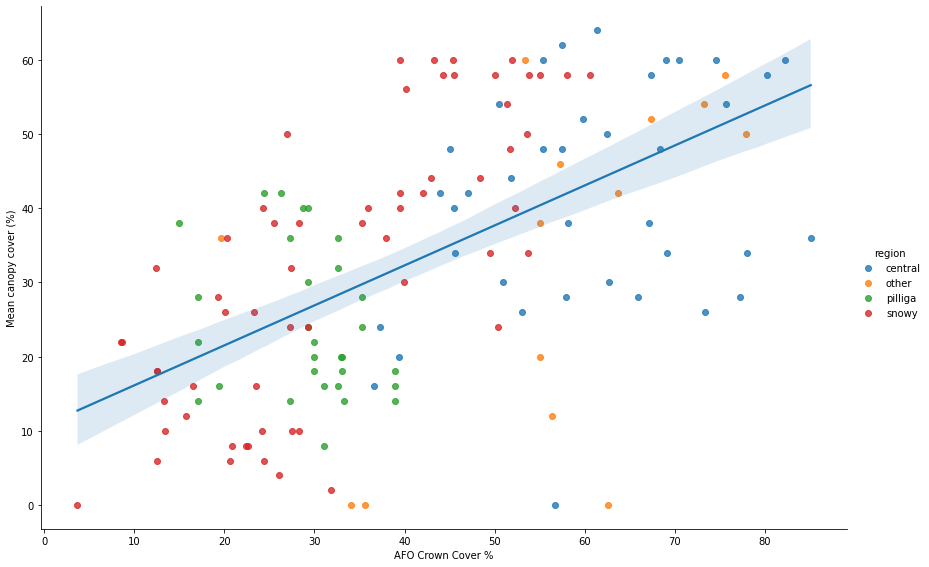

other stats:
pearson r: 0.52 	 r sq: 0.27 	 p: 0.06
central stats:
pearson r: 0.33 	 r sq: 0.11 	 p: 0.04
snowy stats:
pearson r: 0.76 	 r sq: 0.57 	 p: 0.00
pilliga stats:
pearson r: -0.26 	 r sq: 0.07 	 p: 0.16


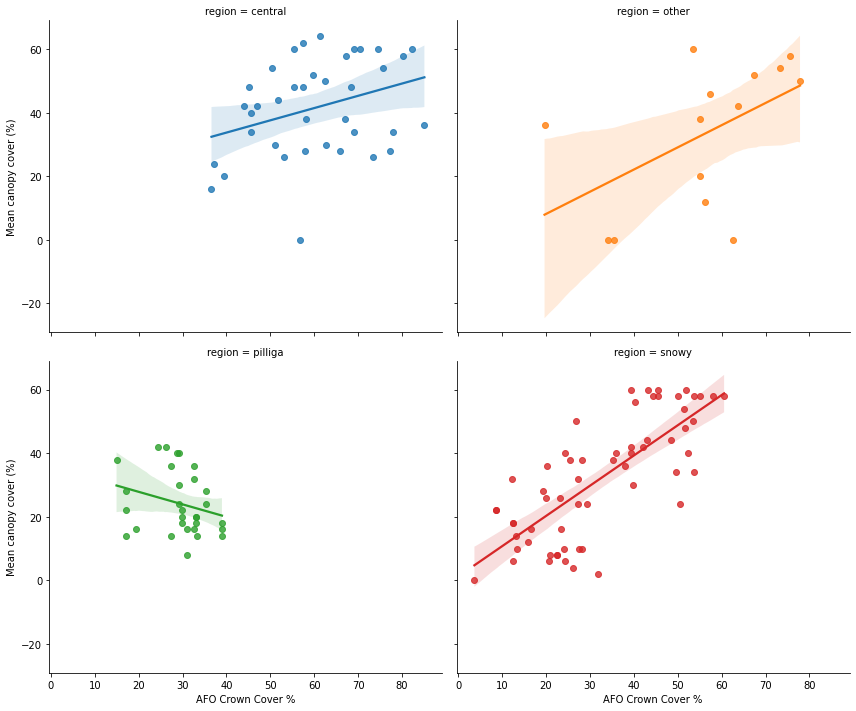

WSF stats:
pearson r: 0.43 	 r sq: 0.18 	 p: 0.08
Heath stats:
pearson r: 0.34 	 r sq: 0.12 	 p: 0.51
DSF stats:
pearson r: 0.62 	 r sq: 0.38 	 p: 0.00


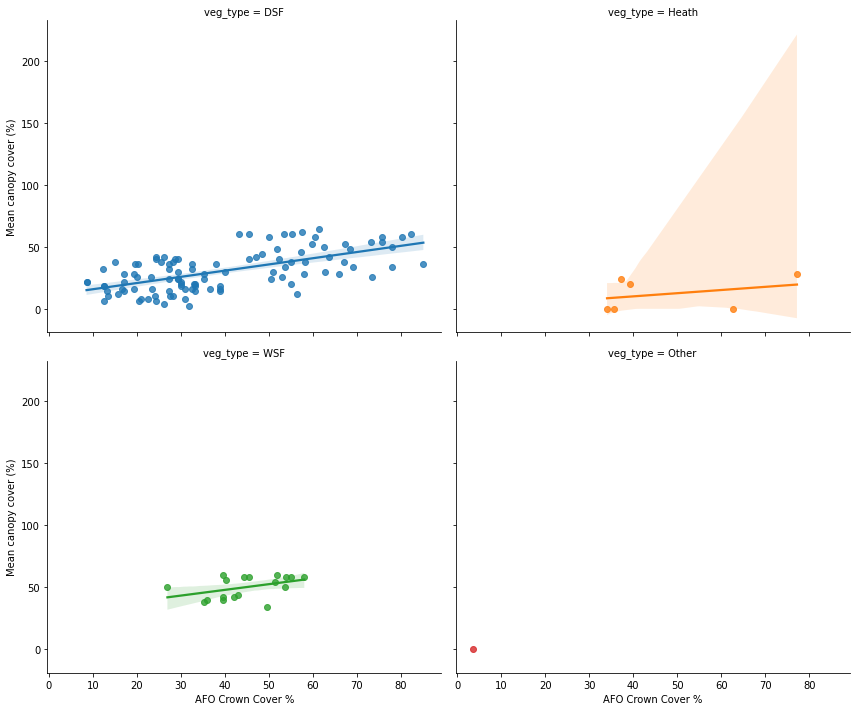

In [19]:
x = 'afo_cc'
y = 'canopy_cov_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO Canopy Height (m) v Mean canopy height (m)
stats:
pearson r: 0.25 	 r sq: 0.06 	 p: 0.00


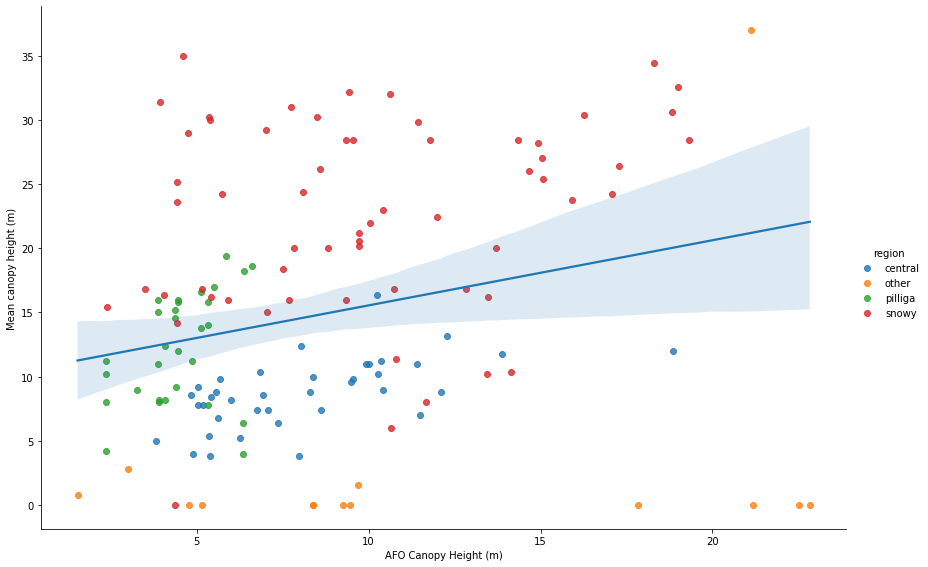

other stats:
pearson r: 0.32 	 r sq: 0.10 	 p: 0.27
central stats:
pearson r: 0.58 	 r sq: 0.34 	 p: 0.00
snowy stats:
pearson r: 0.23 	 r sq: 0.05 	 p: 0.07
pilliga stats:
pearson r: 0.38 	 r sq: 0.14 	 p: 0.04


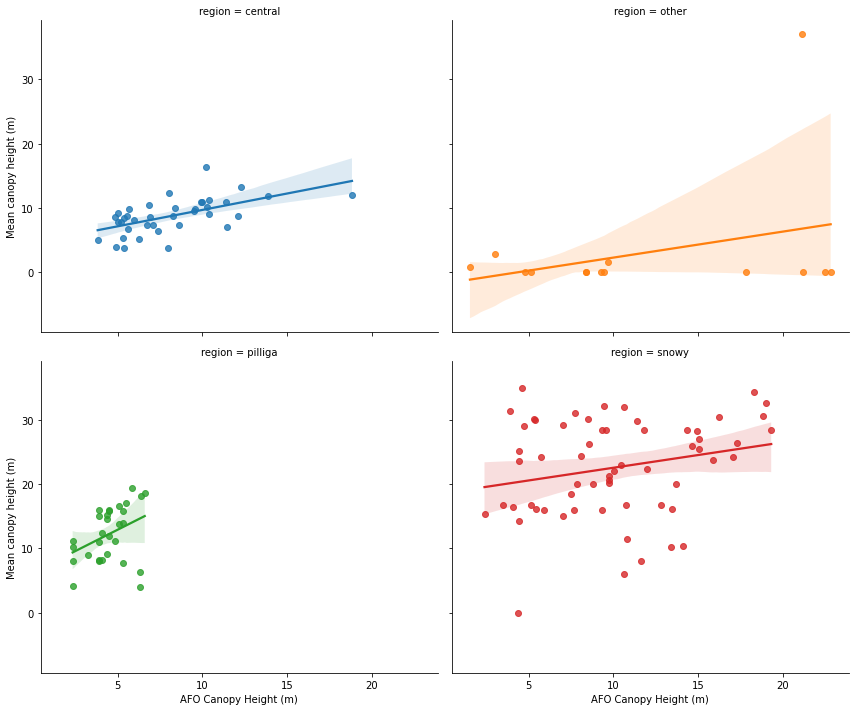

WSF stats:
pearson r: 0.60 	 r sq: 0.36 	 p: 0.01
Heath stats:
pearson r: 0.40 	 r sq: 0.16 	 p: 0.43
DSF stats:
pearson r: 0.06 	 r sq: 0.00 	 p: 0.55


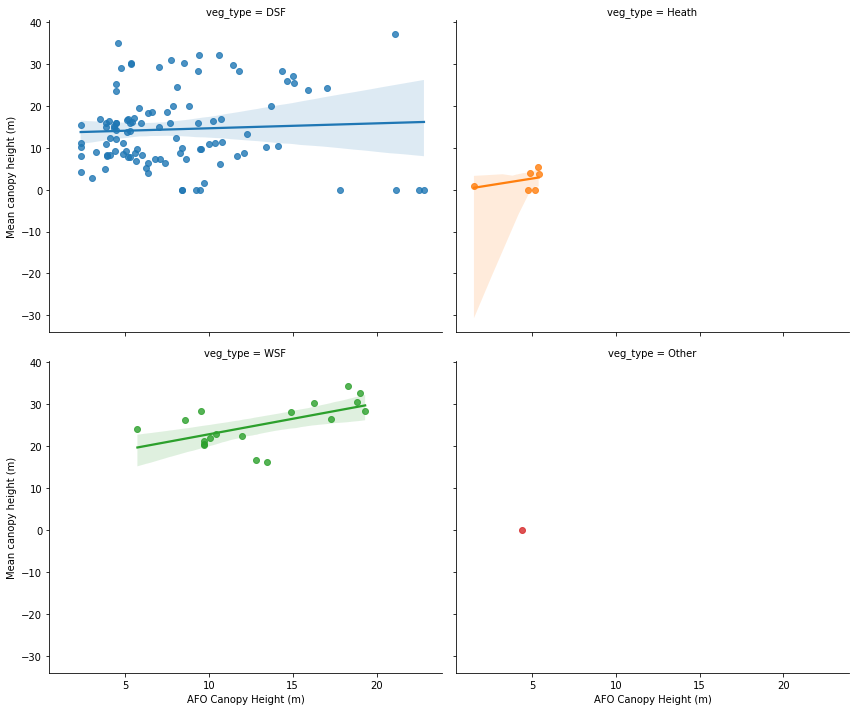

In [20]:
x = 'afo_ch'
y = 'canopy_h_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO Canopy Base Height (m) v Mean canopy height (m)
stats:
pearson r: 0.45 	 r sq: 0.21 	 p: 0.00


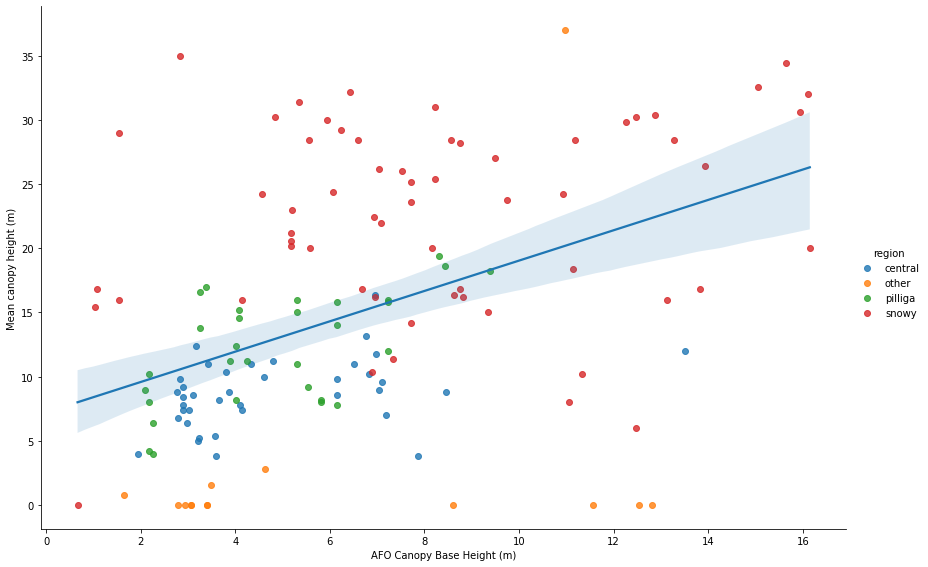

other stats:
pearson r: 0.32 	 r sq: 0.10 	 p: 0.27
central stats:
pearson r: 0.39 	 r sq: 0.15 	 p: 0.02
snowy stats:
pearson r: 0.20 	 r sq: 0.04 	 p: 0.12
pilliga stats:
pearson r: 0.59 	 r sq: 0.35 	 p: 0.00


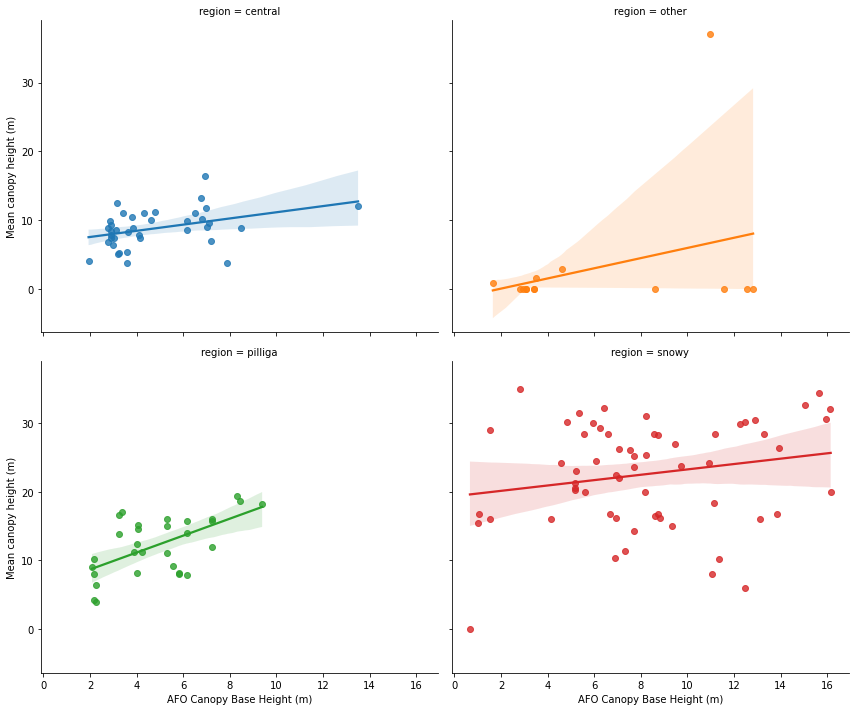

WSF stats:
pearson r: 0.81 	 r sq: 0.65 	 p: 0.00
Heath stats:
pearson r: 0.25 	 r sq: 0.06 	 p: 0.64
DSF stats:
pearson r: 0.32 	 r sq: 0.11 	 p: 0.00


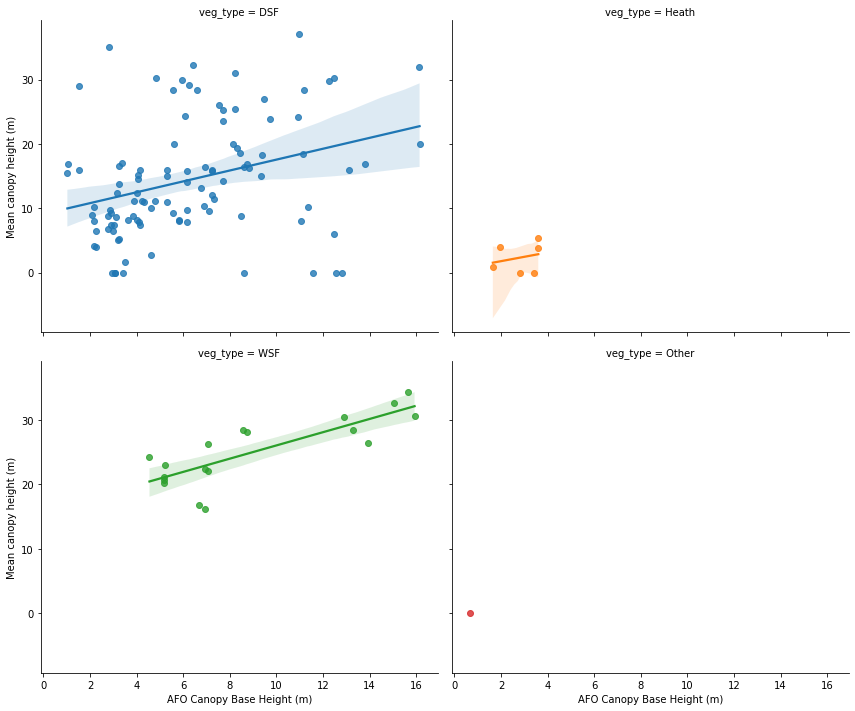

In [21]:
x = 'afo_cbh'
y = 'canopy_h_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO litter fuel load (t/ha) v Mean litter depth (mm)
stats:
pearson r: 0.49 	 r sq: 0.24 	 p: 0.00


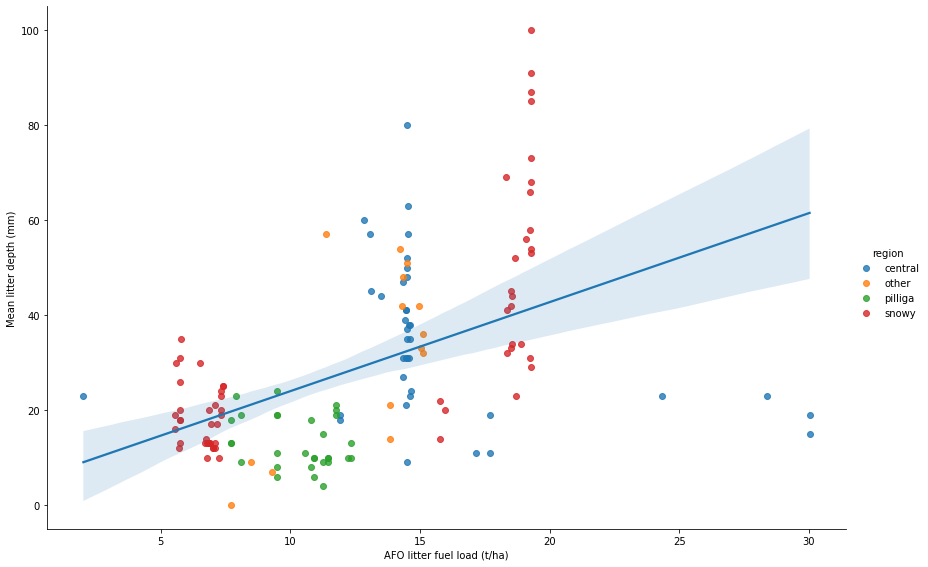

other stats:
pearson r: 0.65 	 r sq: 0.43 	 p: 0.01
central stats:
pearson r: -0.29 	 r sq: 0.09 	 p: 0.08
snowy stats:
pearson r: 0.74 	 r sq: 0.54 	 p: 0.00
pilliga stats:
pearson r: -0.25 	 r sq: 0.06 	 p: 0.18


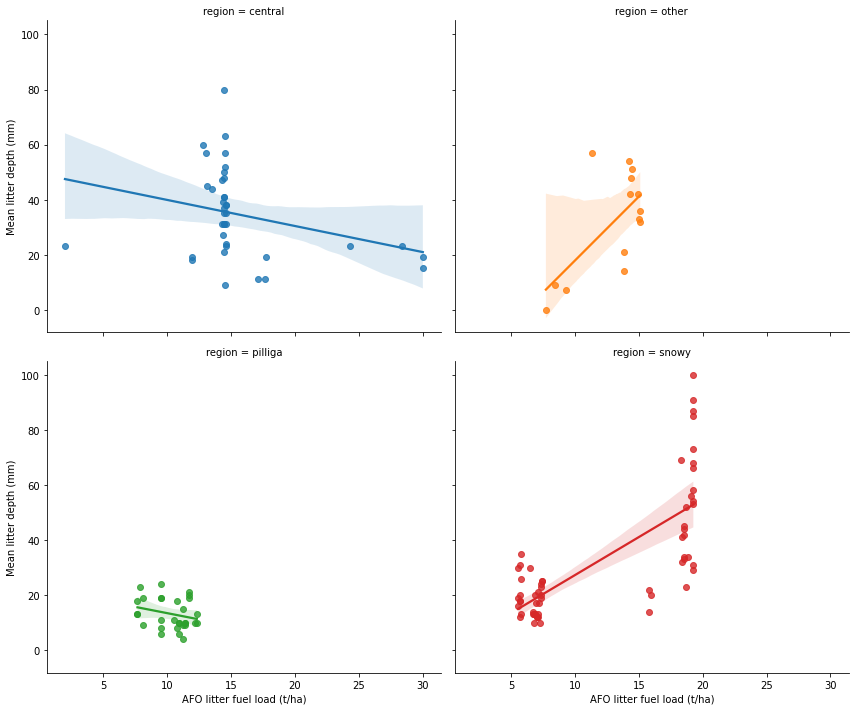

WSF stats:
pearson r: 0.60 	 r sq: 0.36 	 p: 0.01
Heath stats:
pearson r: 0.85 	 r sq: 0.72 	 p: 0.03
DSF stats:
pearson r: 0.42 	 r sq: 0.18 	 p: 0.00


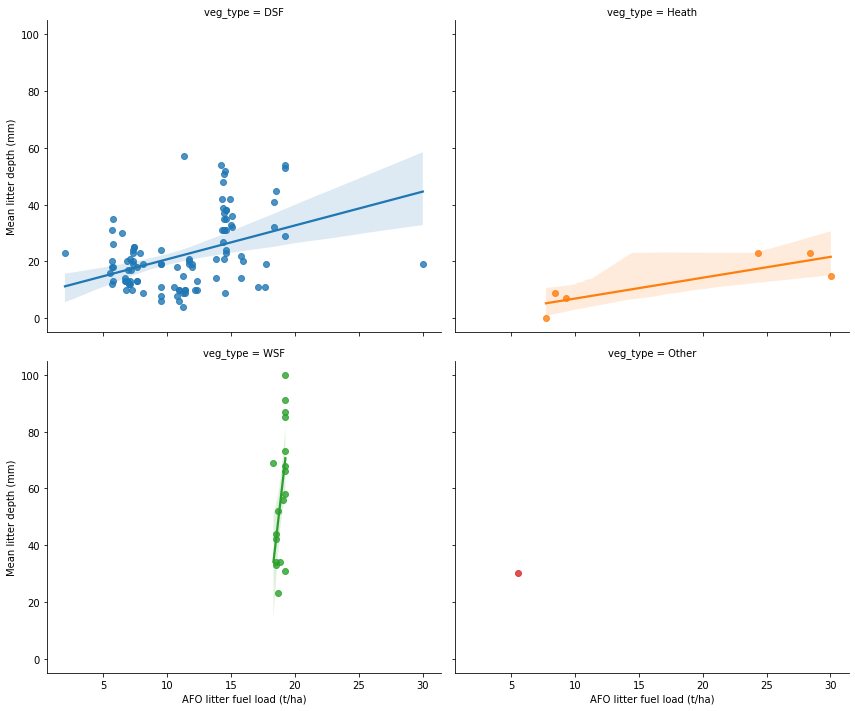

In [22]:
x = 'afo_litter'
y = 'litter_d_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO litter fuel load (t/ha) v Litter fuel load (t/ha)
stats:
pearson r: 0.41 	 r sq: 0.17 	 p: 0.00


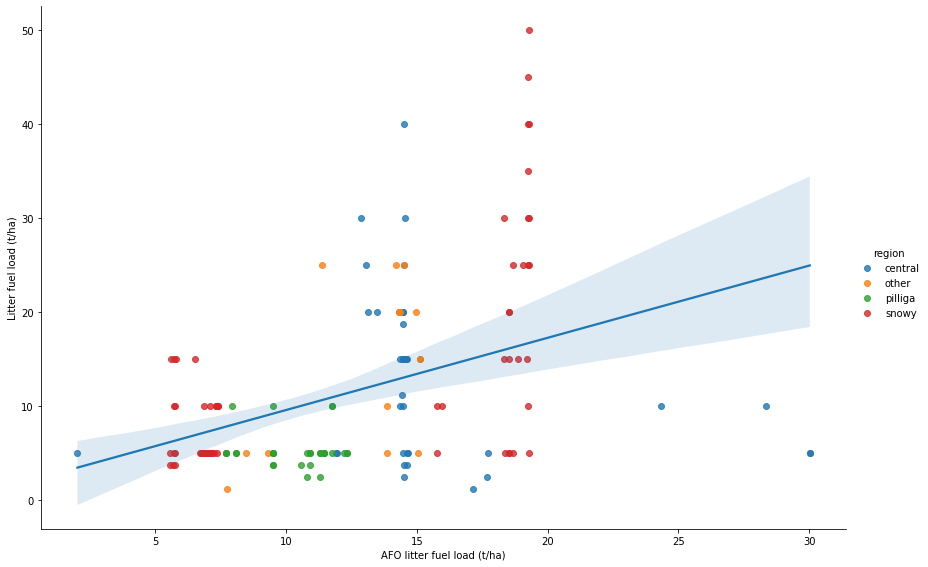

other stats:
pearson r: 0.52 	 r sq: 0.27 	 p: 0.05
central stats:
pearson r: -0.20 	 r sq: 0.04 	 p: 0.23
snowy stats:
pearson r: 0.62 	 r sq: 0.38 	 p: 0.00
pilliga stats:
pearson r: -0.05 	 r sq: 0.00 	 p: 0.80


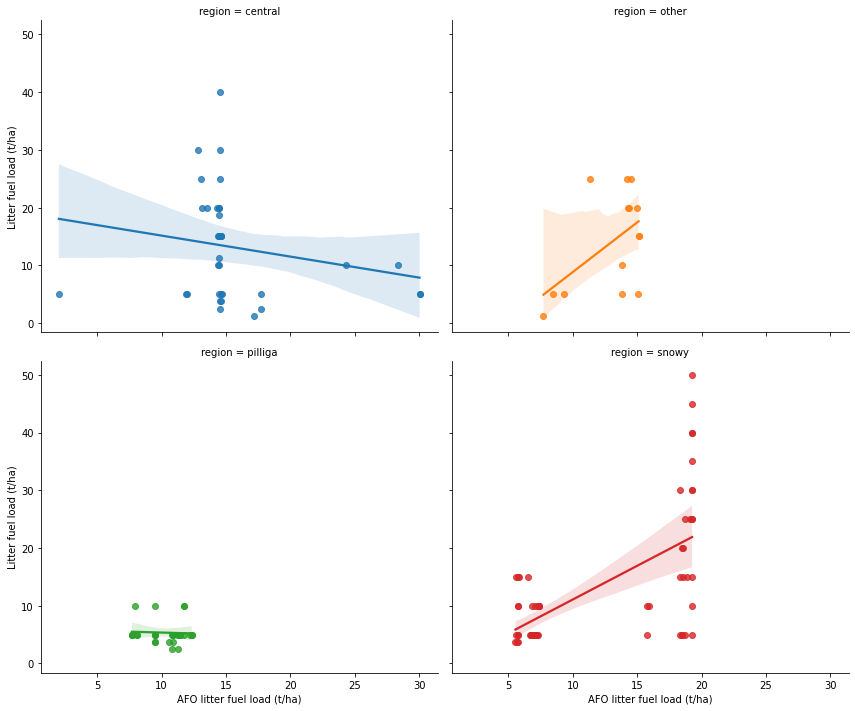

WSF stats:
pearson r: 0.61 	 r sq: 0.38 	 p: 0.01
Heath stats:
pearson r: 0.68 	 r sq: 0.46 	 p: 0.14
DSF stats:
pearson r: 0.25 	 r sq: 0.06 	 p: 0.01


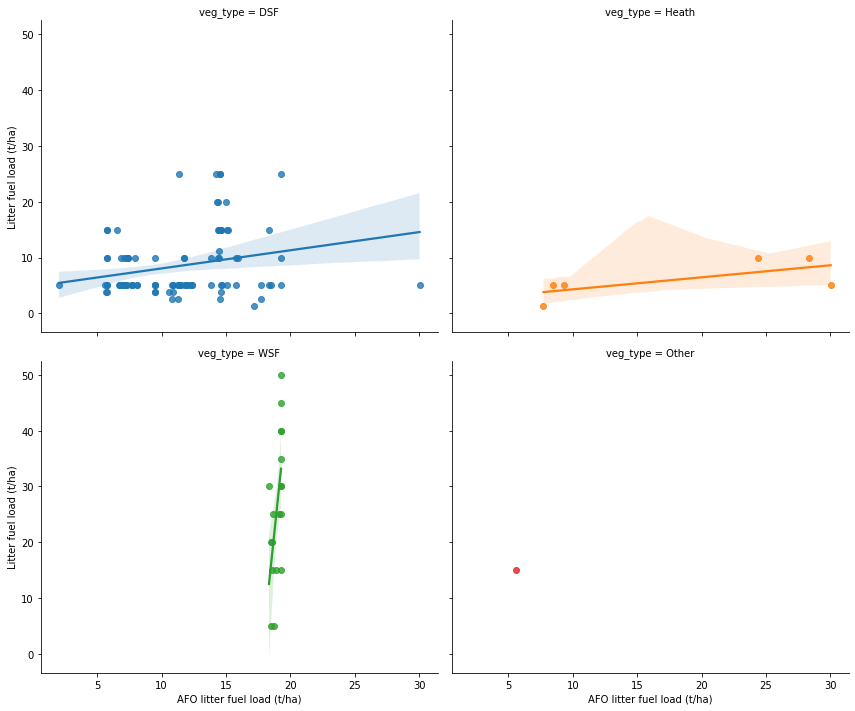

In [23]:
x = 'afo_litter'
y = 'litter_load'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO litter fuel load (t/ha) v AFO surface fuel load (t/ha)
stats:
pearson r: 0.99 	 r sq: 0.98 	 p: 0.00


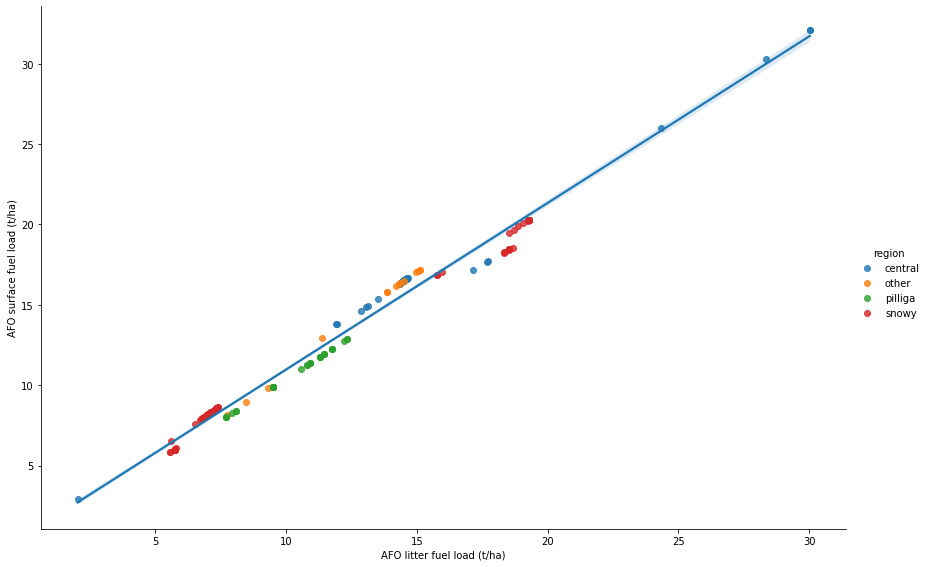

other stats:
pearson r: 1.00 	 r sq: 1.00 	 p: 0.00
central stats:
pearson r: 0.99 	 r sq: 0.99 	 p: 0.00
snowy stats:
pearson r: 1.00 	 r sq: 0.99 	 p: 0.00
pilliga stats:
pearson r: 1.00 	 r sq: 1.00 	 p: 0.00


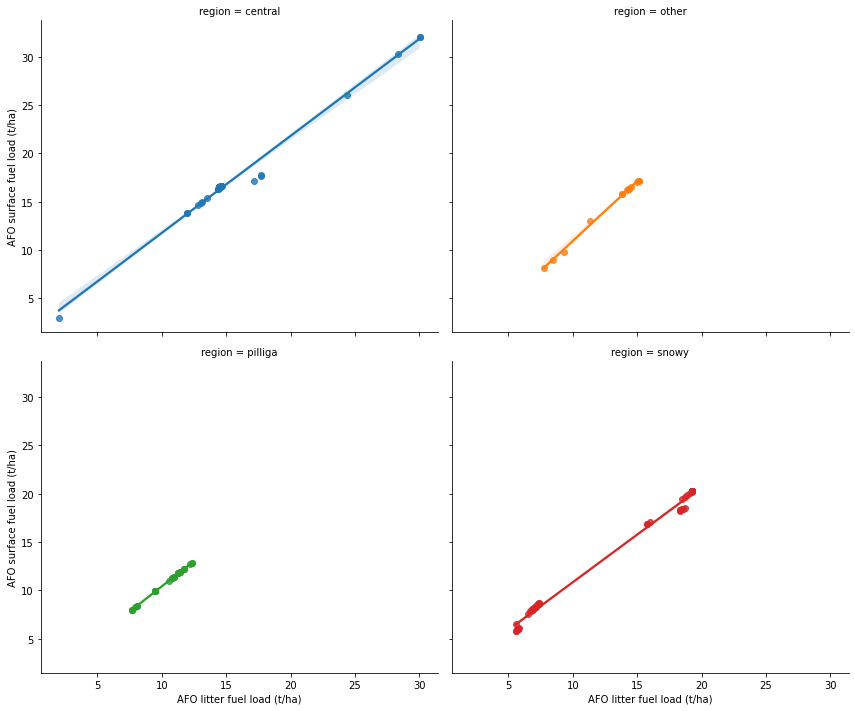

WSF stats:
pearson r: 0.92 	 r sq: 0.85 	 p: 0.00
Heath stats:
pearson r: 1.00 	 r sq: 1.00 	 p: 0.00
DSF stats:
pearson r: 0.99 	 r sq: 0.98 	 p: 0.00


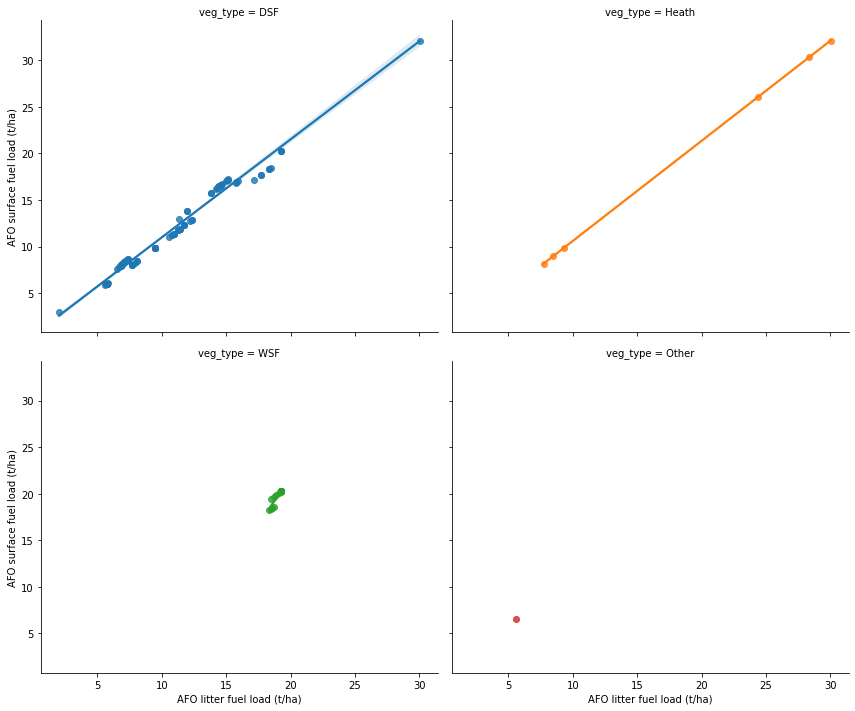

In [24]:
x = 'afo_litter'
y = 'afo_surface'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO surface fuel load (t/ha) v Mean litter depth (mm)
stats:
pearson r: 0.51 	 r sq: 0.26 	 p: 0.00


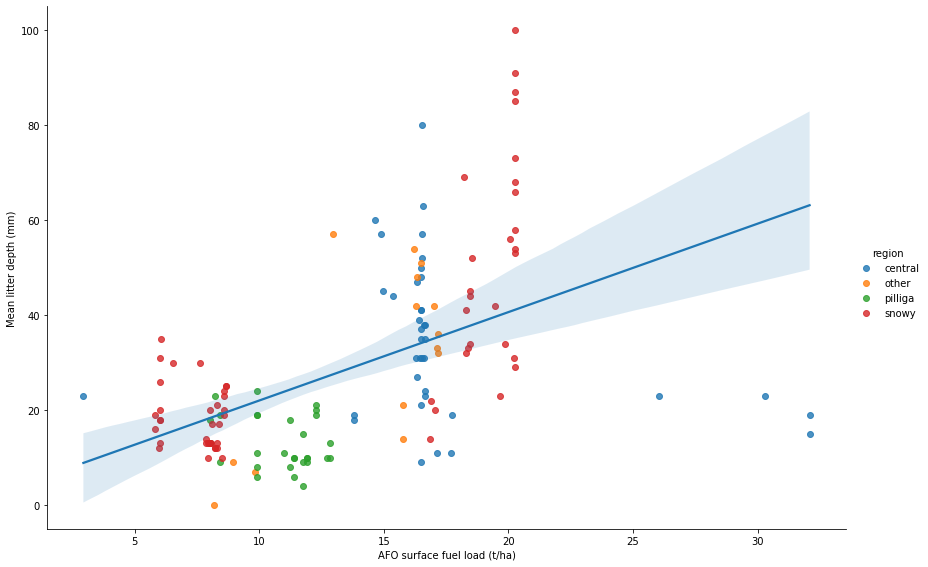

other stats:
pearson r: 0.67 	 r sq: 0.45 	 p: 0.01
central stats:
pearson r: -0.24 	 r sq: 0.06 	 p: 0.14
snowy stats:
pearson r: 0.74 	 r sq: 0.54 	 p: 0.00
pilliga stats:
pearson r: -0.25 	 r sq: 0.06 	 p: 0.18


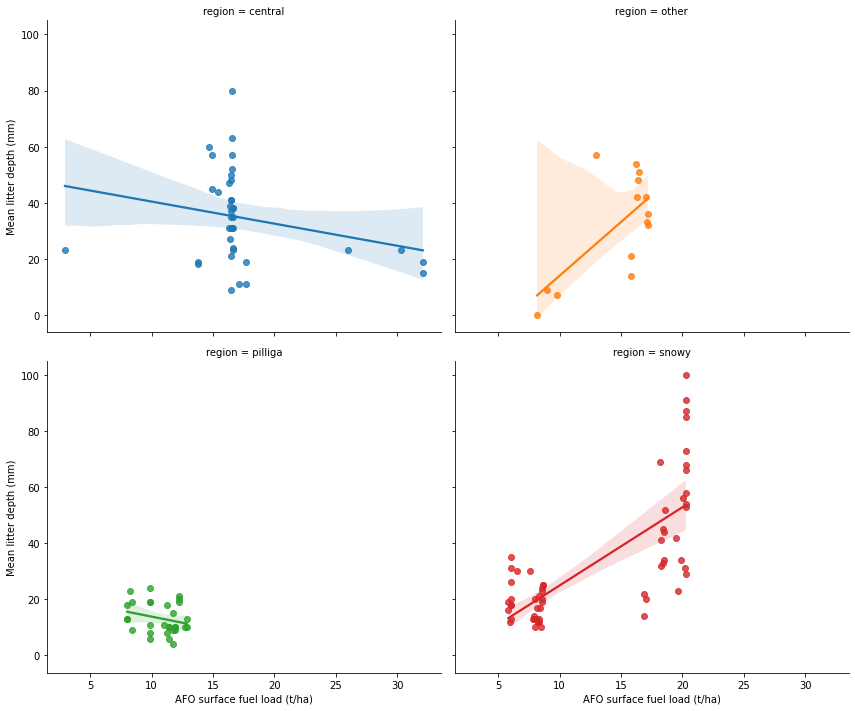

WSF stats:
pearson r: 0.47 	 r sq: 0.22 	 p: 0.05
Heath stats:
pearson r: 0.85 	 r sq: 0.72 	 p: 0.03
DSF stats:
pearson r: 0.47 	 r sq: 0.22 	 p: 0.00


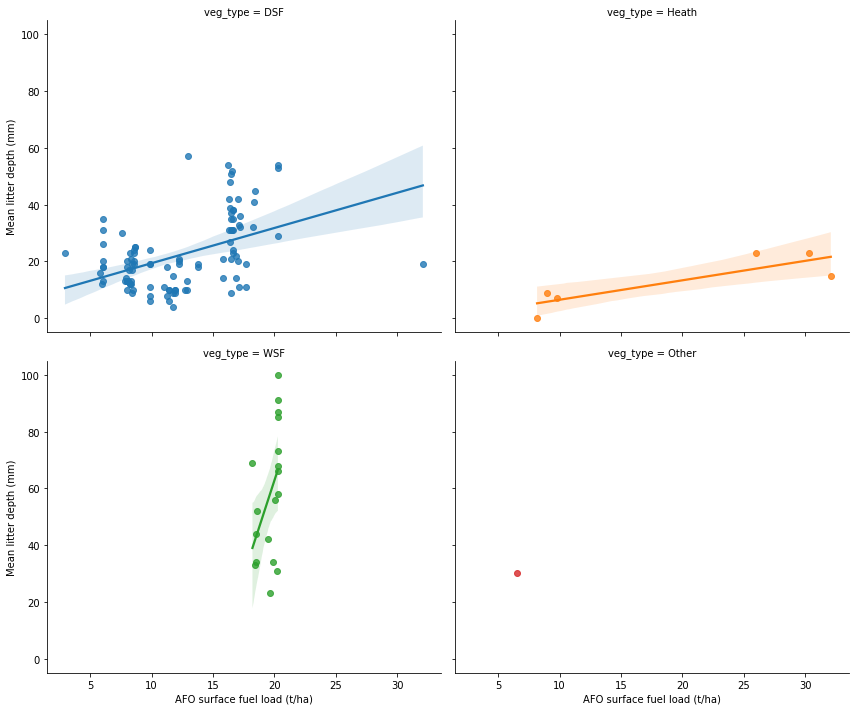

In [25]:
x = 'afo_surface'
y = 'litter_d_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO elevated fuel  load (t/ha) v elevated cover (%)
stats:
pearson r: 0.18 	 r sq: 0.03 	 p: 0.03


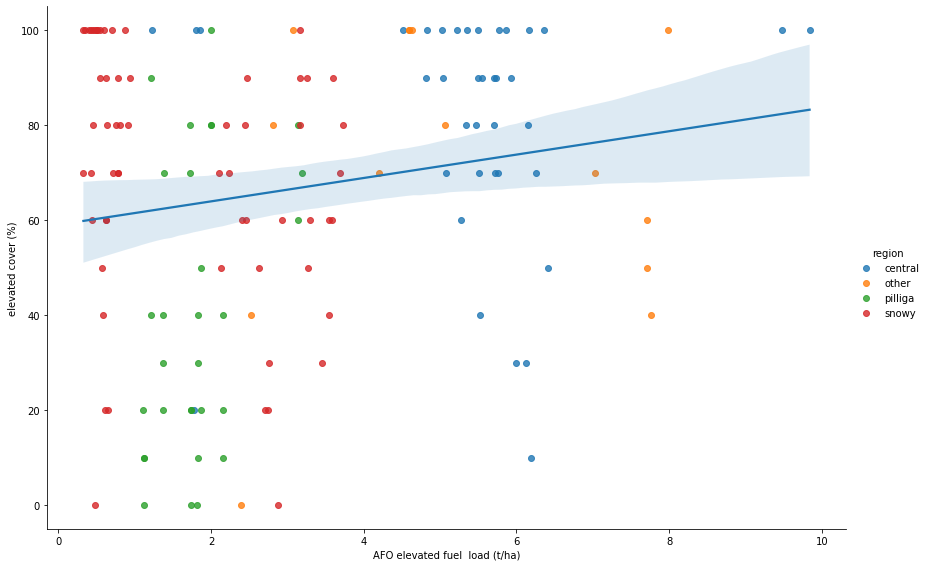

other stats:
pearson r: 0.08 	 r sq: 0.01 	 p: 0.79
central stats:
pearson r: 0.01 	 r sq: 0.00 	 p: 0.96
snowy stats:
pearson r: -0.28 	 r sq: 0.08 	 p: 0.03
pilliga stats:
pearson r: 0.36 	 r sq: 0.13 	 p: 0.05


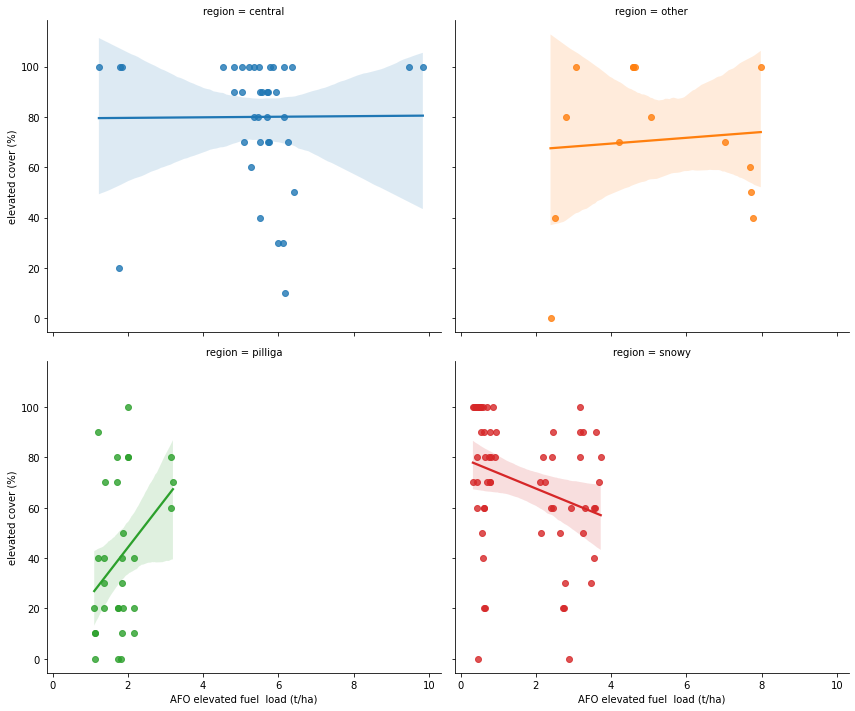

WSF stats:
pearson r: -0.07 	 r sq: 0.01 	 p: 0.78
Heath stats:
pearson r: 0.71 	 r sq: 0.50 	 p: 0.11
DSF stats:
pearson r: 0.05 	 r sq: 0.00 	 p: 0.63


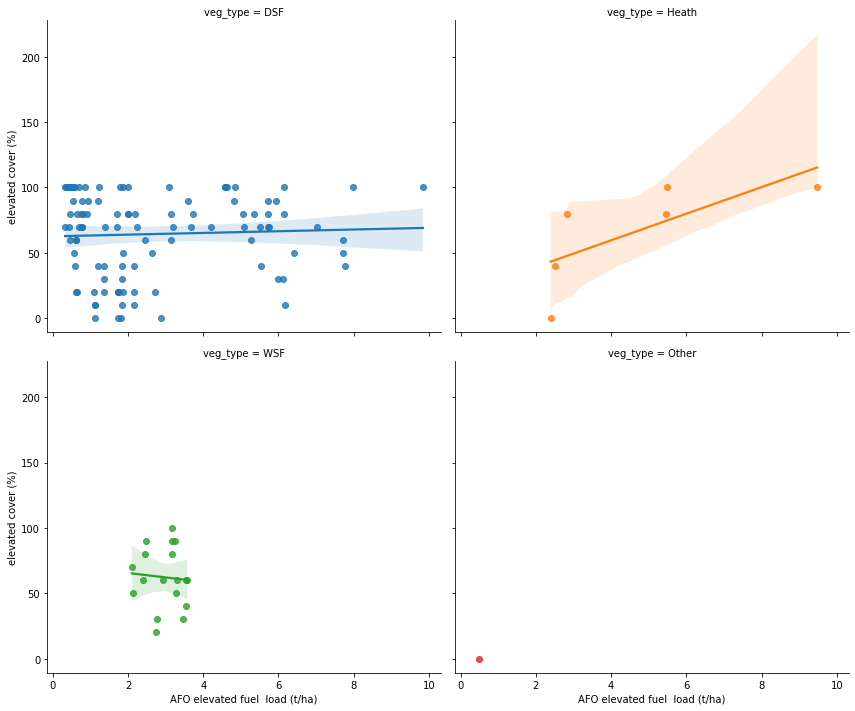

In [26]:
x = 'afo_elevated'
y = 'elev_cov'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO bark fuel load (t/ha) v Mean canopy cover (%)
stats:
pearson r: 0.70 	 r sq: 0.48 	 p: 0.00


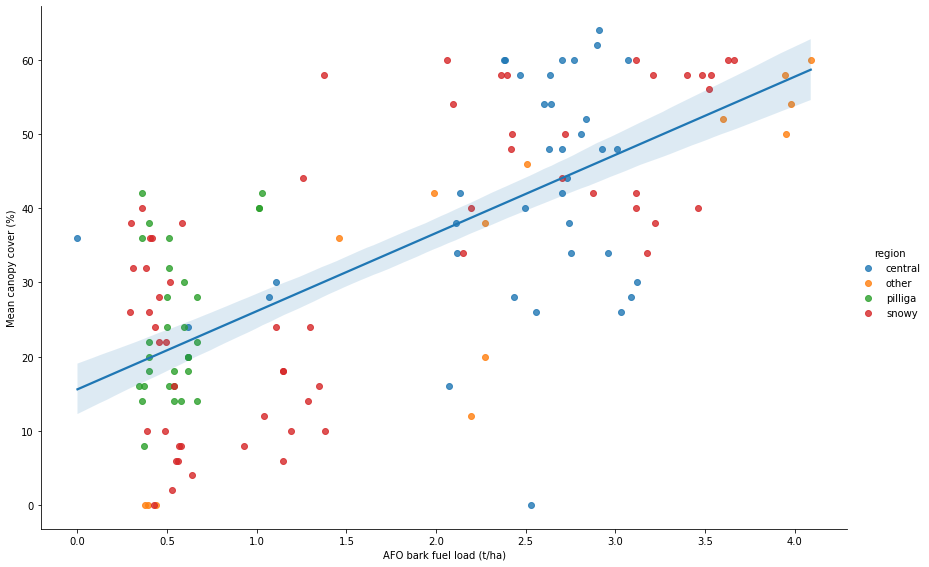

other stats:
pearson r: 0.90 	 r sq: 0.82 	 p: 0.00
central stats:
pearson r: 0.38 	 r sq: 0.14 	 p: 0.02
snowy stats:
pearson r: 0.72 	 r sq: 0.52 	 p: 0.00
pilliga stats:
pearson r: 0.43 	 r sq: 0.18 	 p: 0.02


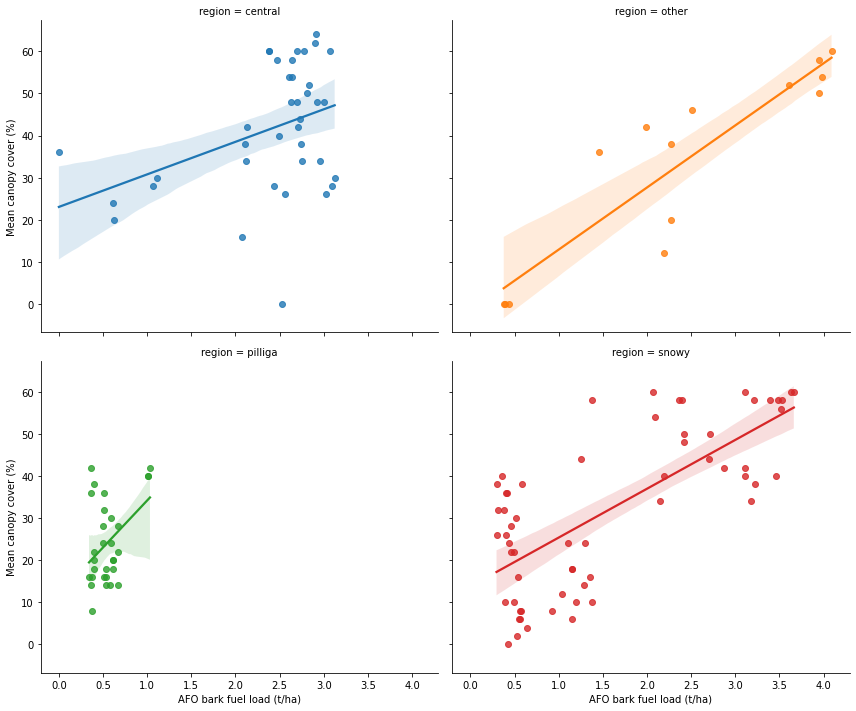

WSF stats:
pearson r: -0.27 	 r sq: 0.07 	 p: 0.28
Heath stats:
pearson r: 0.86 	 r sq: 0.74 	 p: 0.03
DSF stats:
pearson r: 0.66 	 r sq: 0.44 	 p: 0.00


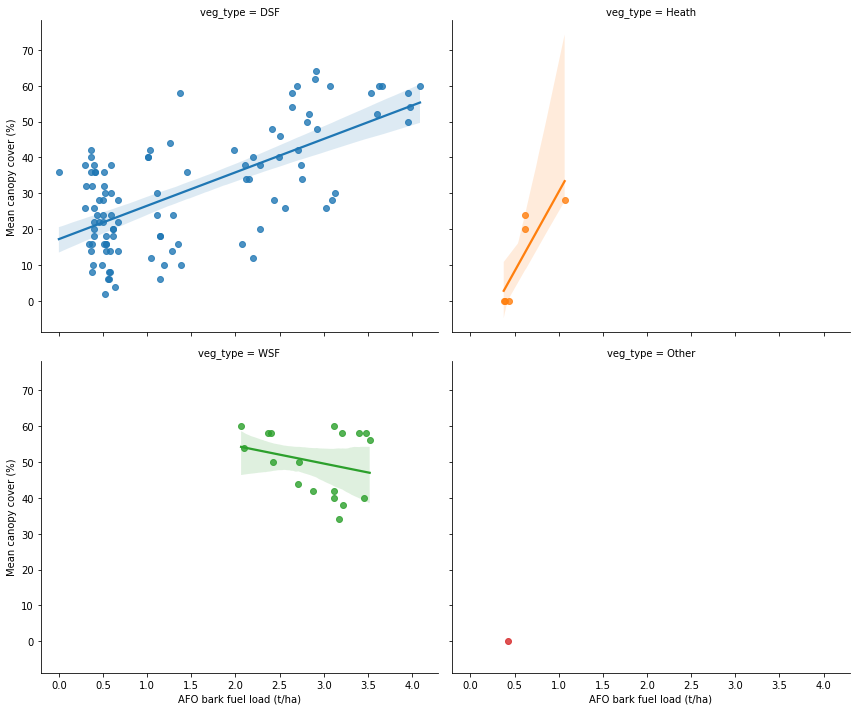

In [27]:
x = 'afo_bark'
y = 'canopy_cov_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

poor correlations may be due to the fine and variable nature of the AFO data. Test how robust the results are to location by sampling with an offset of 20 m

In [28]:
gdf['afo_cc_off'] = read_afo(cc_paths, gdf, offset=20)
labels['afo_cc_off'] = 'AFO Canopy Cover offset 20 m'
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,region,geometry,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,...,representative,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark,afo_cc_off
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,central,POINT (151.28407 -33.58385),DSF,2,4.658635,19.0,100,...,yes,50.941280,10.934896,5.625101,2.781175,17.716690,17.716690,1.855503,3.123432,47.983017
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,central,POINT (151.28377 -33.58408),DSF,2,4.646899,11.0,40,...,None,53.012089,8.507341,6.257932,3.228979,17.689646,17.689646,1.800139,3.030236,55.959557
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,central,POINT (151.28358 -33.58432),DSF,2,4.675196,11.0,10,...,yes,36.591705,15.579016,3.823408,3.203048,17.148125,17.148125,1.230490,2.071327,20.561842
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,central,POINT (151.04137 -34.16933),DSF,None,4.668194,24.0,80,...,yes,82.196129,3.869198,9.999367,4.333815,14.651359,16.660486,6.413480,3.069542,81.923386
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,central,POINT (151.04147 -34.16886),DSF,None,4.658071,9.0,50,...,yes,73.356422,7.731657,5.684369,2.840926,14.508380,16.497902,5.340499,2.556005,83.468933


AFO Crown Cover % v AFO Canopy Cover offset 20 m
stats:
pearson r: 0.84 	 r sq: 0.71 	 p: 0.00


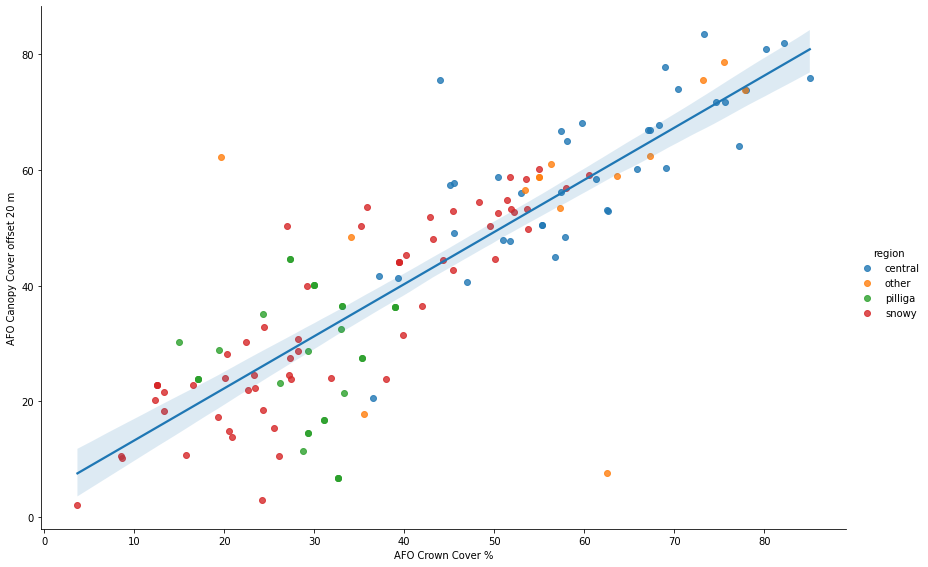

other stats:
pearson r: 0.38 	 r sq: 0.15 	 p: 0.18
central stats:
pearson r: 0.77 	 r sq: 0.60 	 p: 0.00
snowy stats:
pearson r: 0.88 	 r sq: 0.78 	 p: 0.00
pilliga stats:
pearson r: 0.04 	 r sq: 0.00 	 p: 0.82


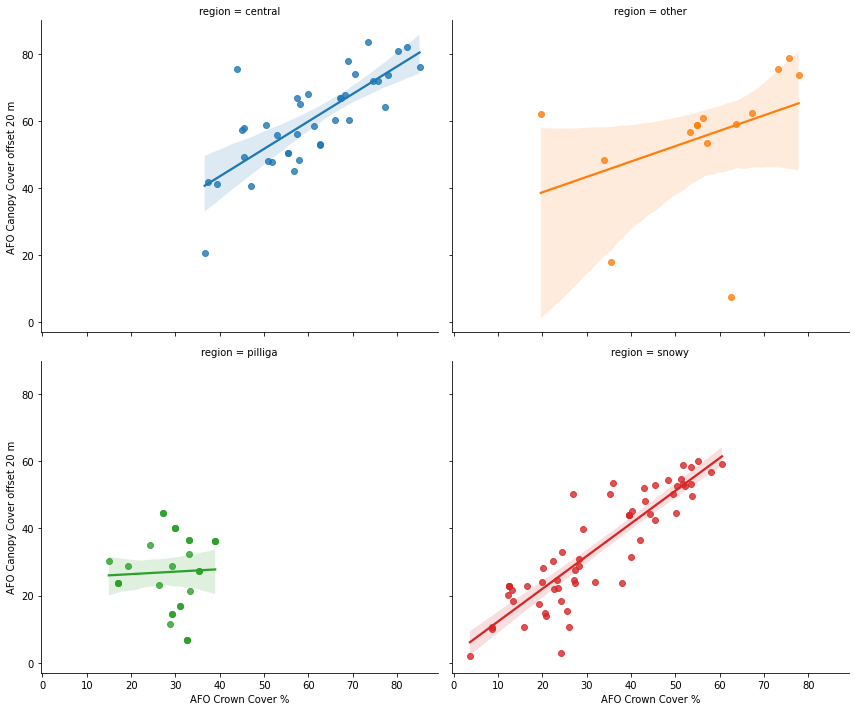

WSF stats:
pearson r: 0.51 	 r sq: 0.26 	 p: 0.03
Heath stats:
pearson r: 0.19 	 r sq: 0.04 	 p: 0.72
DSF stats:
pearson r: 0.88 	 r sq: 0.78 	 p: 0.00


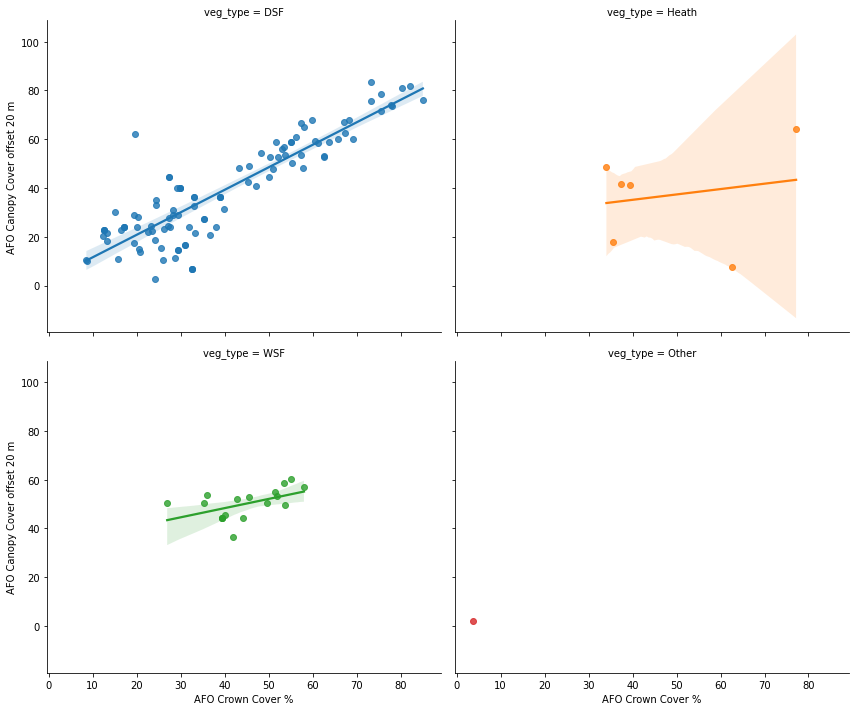

In [29]:
x = 'afo_cc'
y = 'afo_cc_off'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

If the data are so sensitive lets resample it - after a bit of playing it seems that for most of the AFO datasets the greatest improvement comes if we resample to a grid cell size of 30 m

In [30]:
res = 30
lr_cc_paths = rasters_resample(cc_paths, res)
gdf['afo_cc_lr'] = read_afo(lr_cc_paths, gdf)
labels['afo_cc_lr'] = f'AFO Canopy Cover (%) {res} m resolution'
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,region,geometry,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,...,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark,afo_cc_off,afo_cc_lr
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,central,POINT (151.28407 -33.58385),DSF,2,4.658635,19.0,100,...,50.941280,10.934896,5.625101,2.781175,17.716690,17.716690,1.855503,3.123432,47.983017,51.327278
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,central,POINT (151.28377 -33.58408),DSF,2,4.646899,11.0,40,...,53.012089,8.507341,6.257932,3.228979,17.689646,17.689646,1.800139,3.030236,55.959557,47.006329
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,central,POINT (151.28358 -33.58432),DSF,2,4.675196,11.0,10,...,36.591705,15.579016,3.823408,3.203048,17.148125,17.148125,1.230490,2.071327,20.561842,42.904411
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,central,POINT (151.04137 -34.16933),DSF,None,4.668194,24.0,80,...,82.196129,3.869198,9.999367,4.333815,14.651359,16.660486,6.413480,3.069542,81.923386,86.425781
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,central,POINT (151.04147 -34.16886),DSF,None,4.658071,9.0,50,...,73.356422,7.731657,5.684369,2.840926,14.508380,16.497902,5.340499,2.556005,83.468933,67.783195


AFO Canopy Cover (%) 30 m resolution v Mean canopy cover (%)
stats:
pearson r: 0.67 	 r sq: 0.45 	 p: 0.00


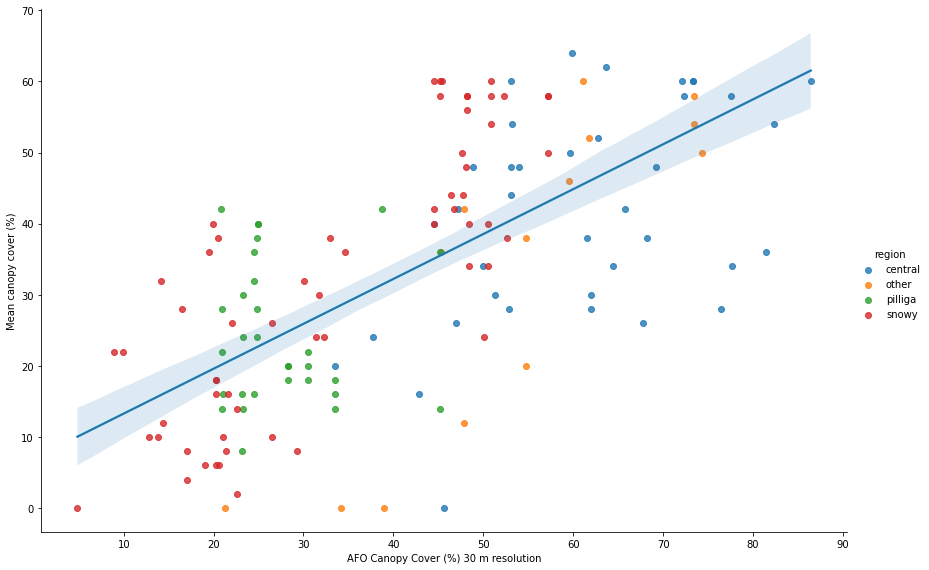

other stats:
pearson r: 0.86 	 r sq: 0.74 	 p: 0.00
central stats:
pearson r: 0.48 	 r sq: 0.23 	 p: 0.00
snowy stats:
pearson r: 0.81 	 r sq: 0.66 	 p: 0.00
pilliga stats:
pearson r: -0.01 	 r sq: 0.00 	 p: 0.97


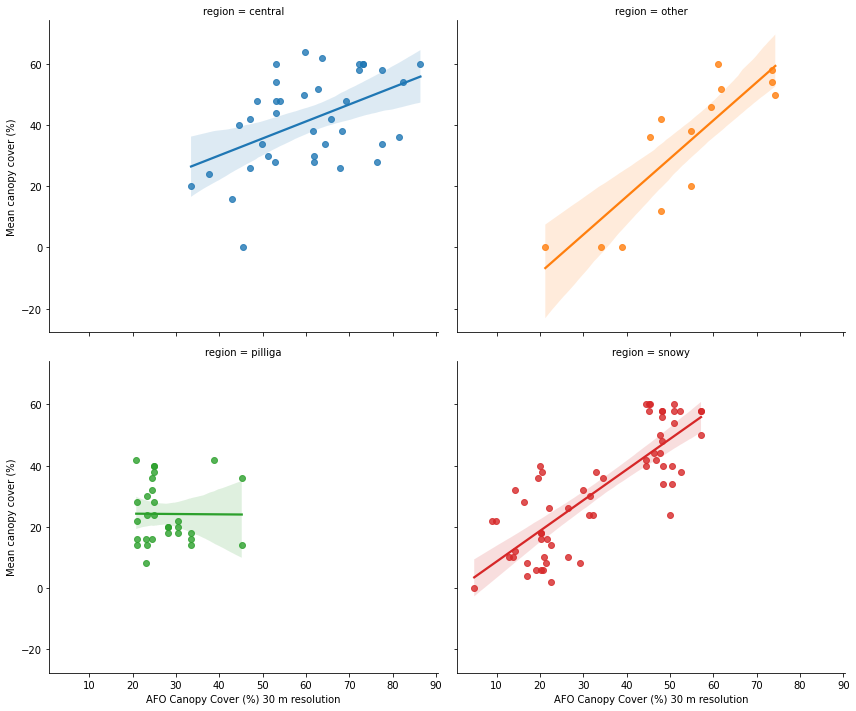

WSF stats:
pearson r: 0.23 	 r sq: 0.05 	 p: 0.36
Heath stats:
pearson r: 0.65 	 r sq: 0.42 	 p: 0.17
DSF stats:
pearson r: 0.67 	 r sq: 0.44 	 p: 0.00


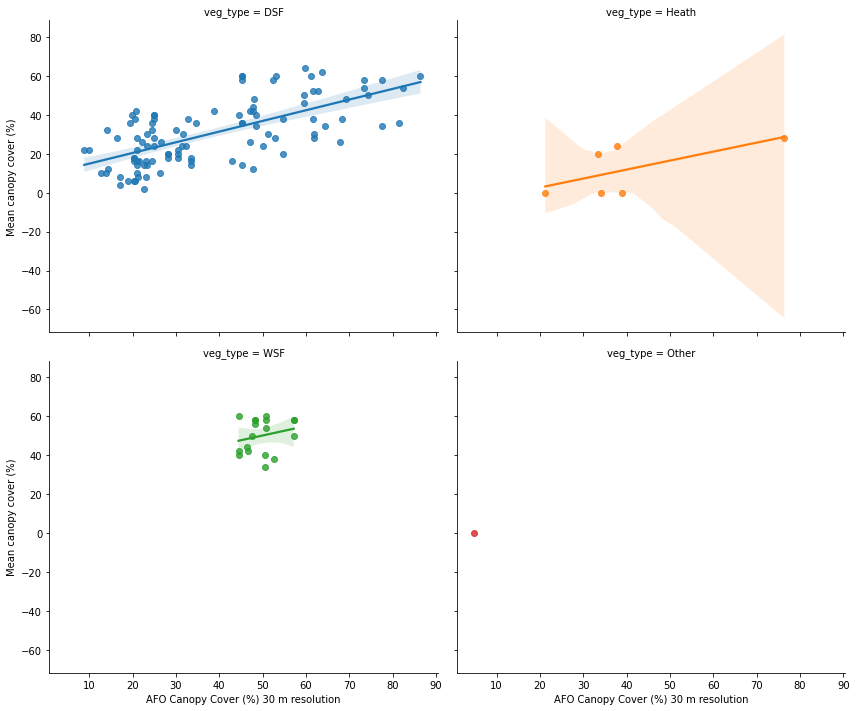

In [31]:
x = 'afo_cc_lr'
y = 'canopy_cov_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
AFO Surface Cover 30 m resolution v Mean litter depth (mm)
stats:
pearson r: 0.50 	 r sq: 0.25 	 p: 0.00


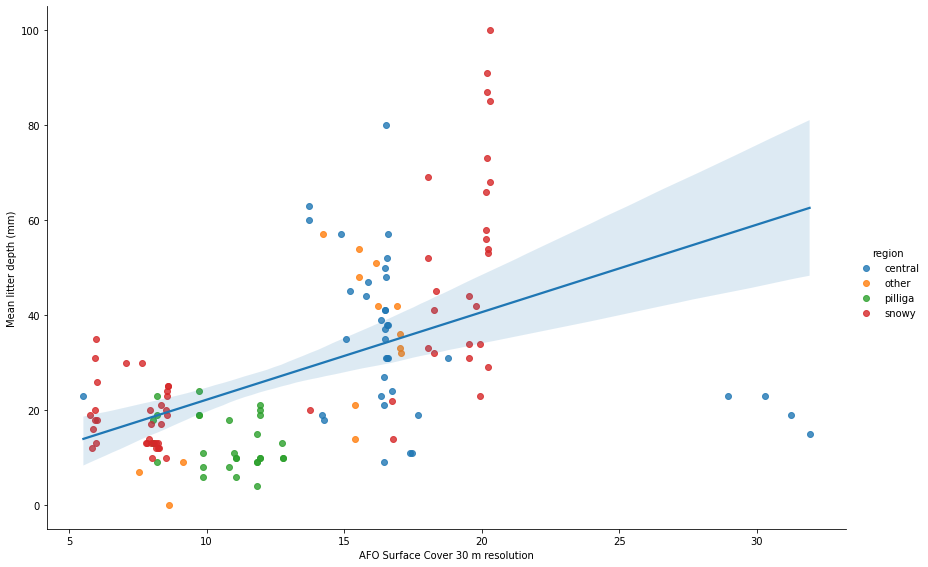

other stats:
pearson r: 0.70 	 r sq: 0.50 	 p: 0.00
central stats:
pearson r: -0.30 	 r sq: 0.09 	 p: 0.06
snowy stats:
pearson r: 0.74 	 r sq: 0.55 	 p: 0.00
pilliga stats:
pearson r: -0.28 	 r sq: 0.08 	 p: 0.13


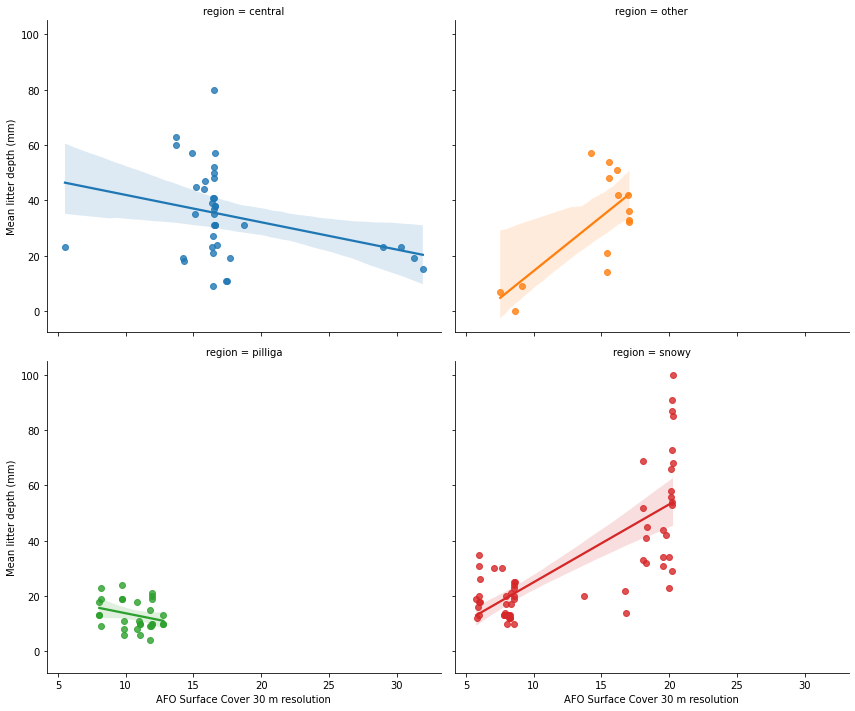

WSF stats:
pearson r: 0.37 	 r sq: 0.13 	 p: 0.14
Heath stats:
pearson r: 0.87 	 r sq: 0.75 	 p: 0.03
DSF stats:
pearson r: 0.48 	 r sq: 0.23 	 p: 0.00


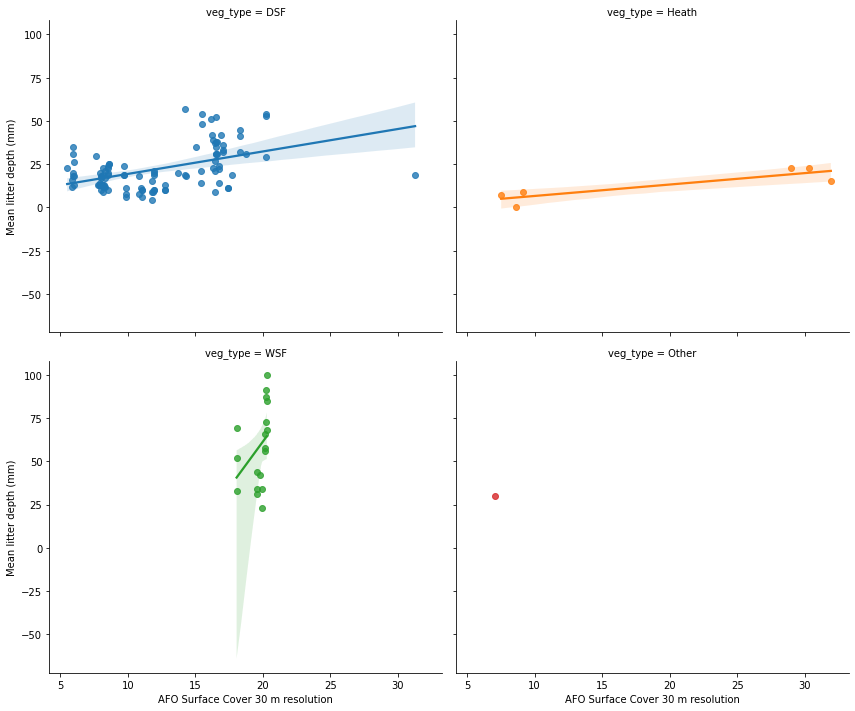

In [32]:
label = 'afo_surface_lr'
paths = rasters_resample(fuel_load_paths, res)
gdf[label] = read_afo(paths, gdf, index=1)
labels[label] = f'AFO Surface Cover {res} m resolution'
x = label
y = 'litter_d_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

## RFS Corporate Data

In [33]:
def read_rfs(path: str, coord_df: GeoDataFrame) -> Series:

    coord_df = coord_df[['geometry']]
    with rasterio.open(path, 'r') as src:
        print(f'Input CRS is: {src.crs}')
        coord_df = coord_df.to_crs(src.crs)
        site_coords = [
            (x,y) for x,y in zip(coord_df['geometry'].x, coord_df['geometry'].y)
        ]
        coord_df['sample_data'] = [x[0] for x in src.sample(site_coords)]
    return coord_df['sample_data']

In [34]:
path = 'spatial_data/RFS/Bark_FuelTypeV211_202109201.tif'
gdf['rfs_bark'] = read_rfs(path,gdf)
labels['rfs_bark'] = 'RFS Bark Fuel Load 02109201'
path = 'spatial_data/RFS/Canopy_FuelTypeV2111.tif'
gdf['rfs_canopy'] = read_rfs(path,gdf)
labels['rfs_canopy'] = 'RFS Canopy Fuel Load 02109201'
path = 'spatial_data/RFS/Elevated_FuelTypeV211_202109201.tif'
gdf['rfs_elevated'] = read_rfs(path,gdf)
labels['rfs_elevated'] = 'RFS Elevated Fuel Load 02109201'
path = 'spatial_data/RFS/Surface_FuelTypeV211_202109201.tif'
gdf['rfs_surface'] = read_rfs(path,gdf)
labels['rfs_surface'] = 'RFS Surface Fuel Load 02109201'
gdf.head()

Input CRS is: EPSG:3308
Input CRS is: EPSG:3308
Input CRS is: EPSG:3308
Input CRS is: EPSG:3308


,id,site,plot,region,geometry,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,...,afo_surface,afo_elevated,afo_bark,afo_cc_off,afo_cc_lr,afo_surface_lr,rfs_bark,rfs_canopy,rfs_elevated,rfs_surface
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,central,POINT (151.28407 -33.58385),DSF,2,4.658635,19.0,100,...,17.716690,1.855503,3.123432,47.983017,51.327278,17.703690,1.355535,9.6,0.364655,6.020303
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,central,POINT (151.28377 -33.58408),DSF,2,4.646899,11.0,40,...,17.689646,1.800139,3.030236,55.959557,47.006329,17.453274,1.355535,9.6,0.364655,6.020303
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,central,POINT (151.28358 -33.58432),DSF,2,4.675196,11.0,10,...,17.148125,1.230490,2.071327,20.561842,42.904411,17.401972,1.355535,9.6,0.364655,6.020303
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,central,POINT (151.04137 -34.16933),DSF,None,4.668194,24.0,80,...,16.660486,6.413480,3.069542,81.923386,86.425781,16.730387,1.414082,3.5,3.012818,8.952730
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,central,POINT (151.04147 -34.16886),DSF,None,4.658071,9.0,50,...,16.497902,5.340499,2.556005,83.468933,67.783195,16.450737,1.414082,3.5,3.012818,8.952730


In [35]:
df_corr = gdf.corr(method='pearson')
df_corr

,loc_accuracy,litter_d_m,litter_cov,litter_load,ns_h_m,ns_cov,ns_load,elev_h_m,elev_cov,elev_load,...,afo_surface,afo_elevated,afo_bark,afo_cc_off,afo_cc_lr,afo_surface_lr,rfs_bark,rfs_canopy,rfs_elevated,rfs_surface
loc_accuracy,1.000000,0.112384,-0.003259,-0.043230,-0.067725,0.081307,-0.013285,0.103546,0.056404,-0.012017,...,0.138038,0.015218,0.166415,0.014614,0.003181,0.146964,0.090835,0.078571,-0.004282,0.119698
litter_d_m,0.112384,1.000000,0.317014,0.919460,0.224079,0.138200,0.188182,0.280819,0.143506,0.124034,...,0.508517,0.404072,0.690024,0.443687,0.444516,0.504181,0.619953,0.133364,0.121601,0.407038
litter_cov,-0.003259,0.317014,1.000000,0.362295,0.001048,0.264071,0.014278,0.026849,0.103379,0.003211,...,0.120700,0.090090,0.121293,0.026580,0.045176,0.122092,0.146062,0.082477,0.013880,0.241863
litter_load,-0.043230,0.919460,0.362295,1.000000,0.239996,0.167273,0.188283,0.222281,0.103818,0.053984,...,0.426184,0.323718,0.568674,0.343604,0.344686,0.421237,0.511792,0.093358,0.113079,0.344984
ns_h_m,-0.067725,0.224079,0.001048,0.239996,1.000000,0.553662,0.455636,0.460361,0.383685,0.120231,...,0.082085,0.087025,0.052253,-0.031682,-0.081089,0.092972,0.015352,-0.185090,0.129139,-0.083556
ns_cov,0.081307,0.138200,0.264071,0.167273,0.553662,1.000000,0.214662,0.314499,0.383645,-0.024871,...,0.065870,-0.148173,-0.035989,-0.116060,-0.154049,0.062075,-0.102012,0.237846,-0.143601,-0.091579
ns_load,-0.013285,0.188182,0.014278,0.188283,0.455636,0.214662,1.000000,0.559535,0.388701,0.592559,...,0.014287,0.180432,-0.001745,0.017961,0.007939,0.023296,0.079989,-0.220701,0.352439,0.163403
elev_h_m,0.103546,0.280819,0.026849,0.222281,0.460361,0.314499,0.559535,1.000000,0.843357,0.557096,...,0.223944,0.298951,0.312944,0.197713,0.178519,0.228524,0.282233,0.019912,0.271427,0.104055
elev_cov,0.056404,0.143506,0.103379,0.103818,0.383685,0.383645,0.388701,0.843357,1.000000,0.457202,...,0.143060,0.178040,0.221774,0.108662,0.088434,0.145845,0.169052,0.170030,0.113547,-0.053214
elev_load,-0.012017,0.124034,0.003211,0.053984,0.120231,-0.024871,0.592559,0.557096,0.457202,1.000000,...,0.075452,0.163522,0.069148,0.034360,0.032872,0.090211,0.106926,-0.059344,0.268345,0.139048


In [36]:
df_corr.columns.values

array(['loc_accuracy', 'litter_d_m', 'litter_cov', 'litter_load',
       'ns_h_m', 'ns_cov', 'ns_load', 'elev_h_m', 'elev_cov', 'elev_load',
       'bark_load', 'canopy_h_m', 'canopy_cov_m', 'afo_cc', 'afo_lfd',
       'afo_ch', 'afo_cbh', 'afo_litter', 'afo_surface', 'afo_elevated',
       'afo_bark', 'afo_cc_off', 'afo_cc_lr', 'afo_surface_lr',
       'rfs_bark', 'rfs_canopy', 'rfs_elevated', 'rfs_surface'],
      dtype=object)

In [37]:
rfs_keys = ['rfs_bark', 'rfs_canopy', 'rfs_elevated', 'rfs_surface']

In [38]:
df_corr.loc[field_keys, afo_keys]

,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
litter_d_m,0.353170,-0.149710,0.495831,0.193215,0.490384,0.508517,0.404072,0.690024
litter_cov,0.020424,-0.102912,0.244053,0.164425,0.097956,0.120700,0.090090,0.121293
litter_load,0.258593,-0.101412,0.411155,0.165026,0.408429,0.426184,0.323718,0.568674
ns_h_m,-0.074975,0.103687,-0.129795,-0.187325,0.080328,0.082085,0.087025,0.052253
ns_cov,-0.184162,0.164300,0.034459,0.053096,0.081935,0.065870,-0.148173,-0.035989
ns_load,0.006199,0.118763,-0.184981,-0.201827,-0.023631,0.014287,0.180432,-0.001745
elev_h_m,0.160490,0.212856,0.098199,-0.047572,0.198271,0.223944,0.298951,0.312944
elev_cov,0.084107,0.255311,0.059883,-0.063541,0.113997,0.143060,0.178040,0.221774
elev_load,0.012920,0.182625,-0.046872,-0.117747,0.057657,0.075452,0.163522,0.069148
bark_load,-0.037023,-0.030943,0.325142,0.195205,0.096099,0.093692,-0.094156,0.167462


In [39]:
df_corr.loc[field_keys, rfs_keys]

,rfs_bark,rfs_canopy,rfs_elevated,rfs_surface
litter_d_m,0.619953,0.133364,0.121601,0.407038
litter_cov,0.146062,0.082477,0.013880,0.241863
litter_load,0.511792,0.093358,0.113079,0.344984
ns_h_m,0.015352,-0.185090,0.129139,-0.083556
ns_cov,-0.102012,0.237846,-0.143601,-0.091579
ns_load,0.079989,-0.220701,0.352439,0.163403
elev_h_m,0.282233,0.019912,0.271427,0.104055
elev_cov,0.169052,0.170030,0.113547,-0.053214
elev_load,0.106926,-0.059344,0.268345,0.139048
bark_load,0.157634,0.368705,-0.176854,0.177658


In [40]:
df_corr.loc[afo_keys, rfs_keys]

,rfs_bark,rfs_canopy,rfs_elevated,rfs_surface
afo_cc,0.543068,-0.268005,0.515086,0.509988
afo_lfd,-0.167509,-0.019287,0.017058,-0.278017
afo_ch,0.471689,0.293119,0.001693,0.379728
afo_cbh,0.104881,0.407296,-0.264039,0.091228
afo_litter,0.311204,-0.140179,0.491073,0.572980
afo_surface,0.361935,-0.169445,0.550203,0.613967
afo_elevated,0.591552,-0.499266,0.784142,0.677641
afo_bark,0.821023,0.090864,0.241495,0.478344


AFO bark fuel load (t/ha) v RFS Bark Fuel Load 02109201
stats:
pearson r: 0.82 	 r sq: 0.67 	 p: 0.00


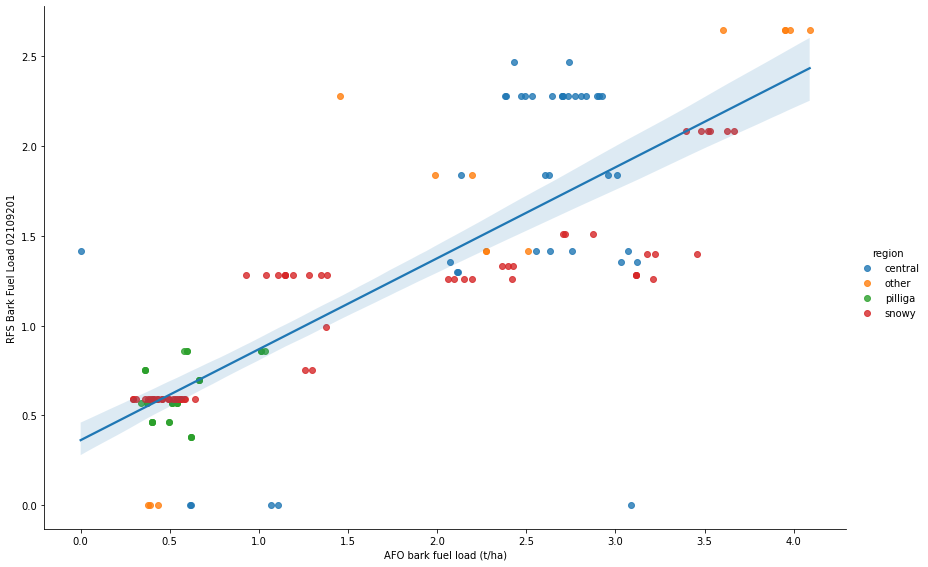

other stats:
pearson r: 0.91 	 r sq: 0.83 	 p: 0.00
central stats:
pearson r: 0.59 	 r sq: 0.35 	 p: 0.00
snowy stats:
pearson r: 0.89 	 r sq: 0.79 	 p: 0.00
pilliga stats:
pearson r: 0.47 	 r sq: 0.22 	 p: 0.01


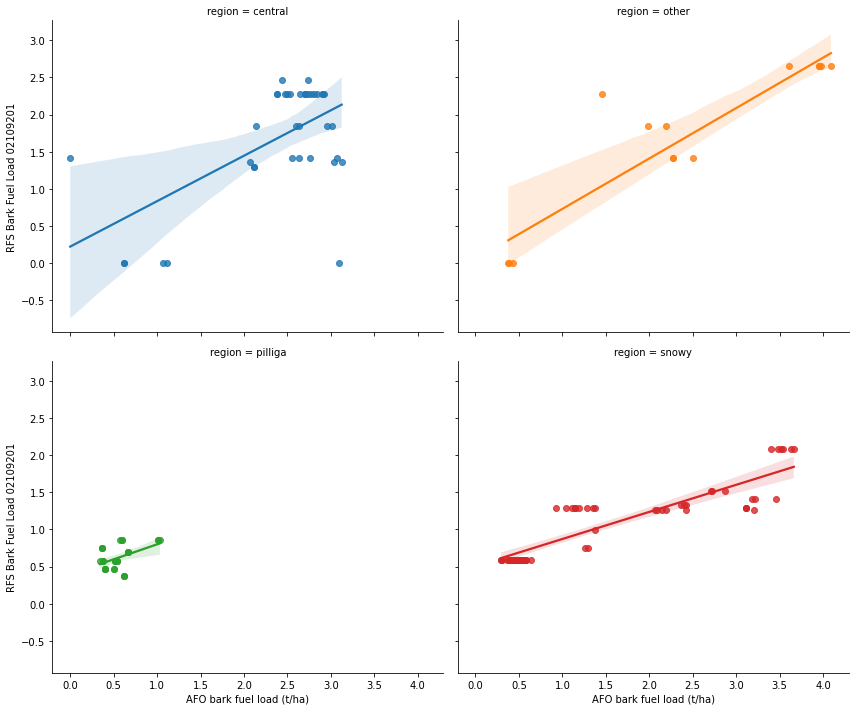

WSF stats:
pearson r: 0.56 	 r sq: 0.31 	 p: 0.02
Heath stats:
pearson r: 0.00 	 r sq: 0.00 	 p: 1.00
DSF stats:
pearson r: 0.85 	 r sq: 0.72 	 p: 0.00


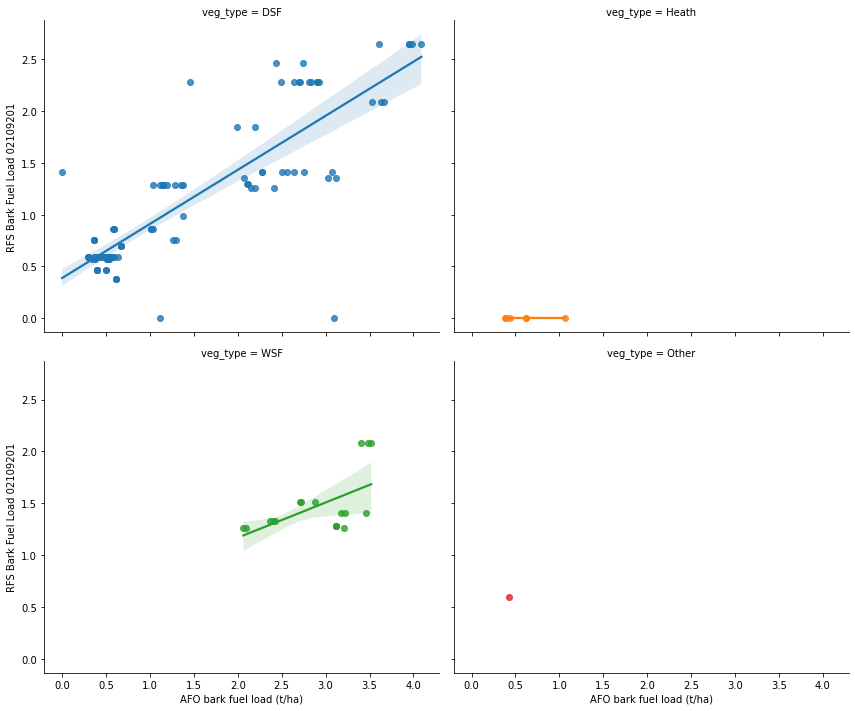

In [41]:
x = 'afo_bark'
y = 'rfs_bark'
reg_plot(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='veg_type')
plt.show()

AFO elevated fuel  load (t/ha) v RFS Elevated Fuel Load 02109201
stats:
pearson r: 0.78 	 r sq: 0.61 	 p: 0.00


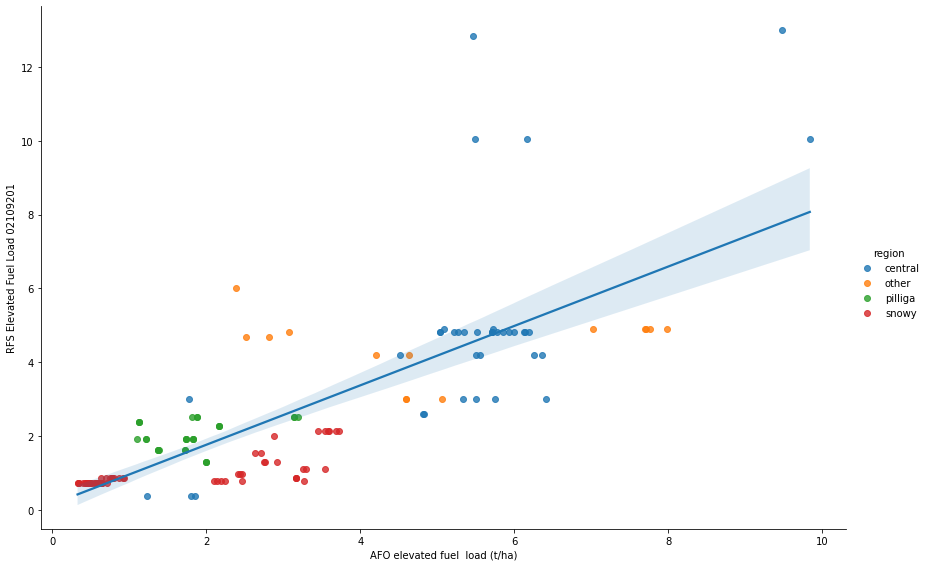

other stats:
pearson r: 0.06 	 r sq: 0.00 	 p: 0.83
central stats:
pearson r: 0.68 	 r sq: 0.46 	 p: 0.00
snowy stats:
pearson r: 0.73 	 r sq: 0.53 	 p: 0.00
pilliga stats:
pearson r: 0.32 	 r sq: 0.10 	 p: 0.09


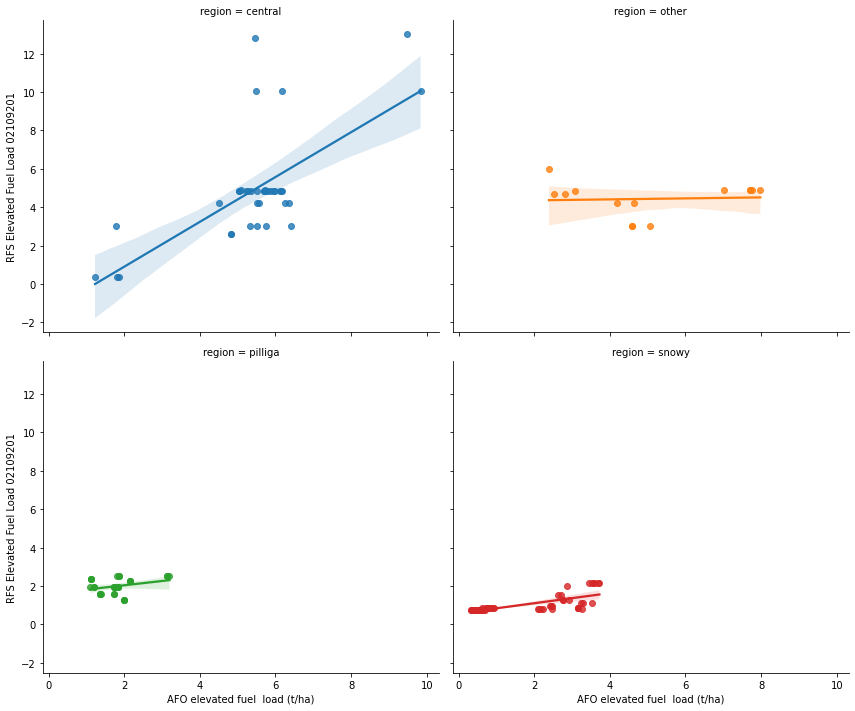

WSF stats:
pearson r: 0.56 	 r sq: 0.31 	 p: 0.02
Heath stats:
pearson r: 0.88 	 r sq: 0.77 	 p: 0.02
DSF stats:
pearson r: 0.87 	 r sq: 0.75 	 p: 0.00


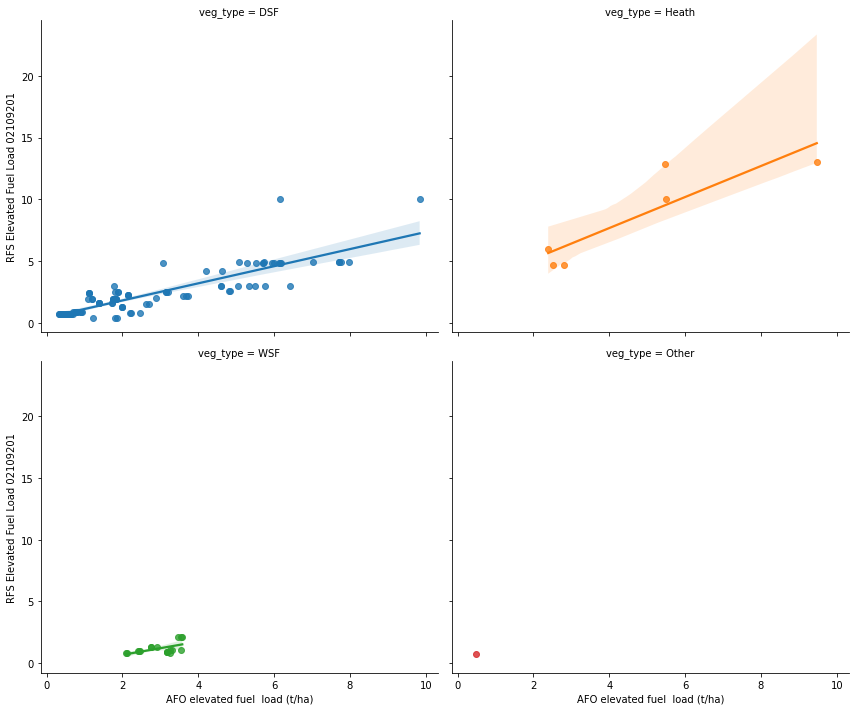

In [42]:
x = 'afo_elevated'
y = 'rfs_elevated'
reg_plot(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='veg_type')
plt.show()

AFO surface fuel load (t/ha) v RFS Surface Fuel Load 02109201
stats:
pearson r: 0.61 	 r sq: 0.38 	 p: 0.00


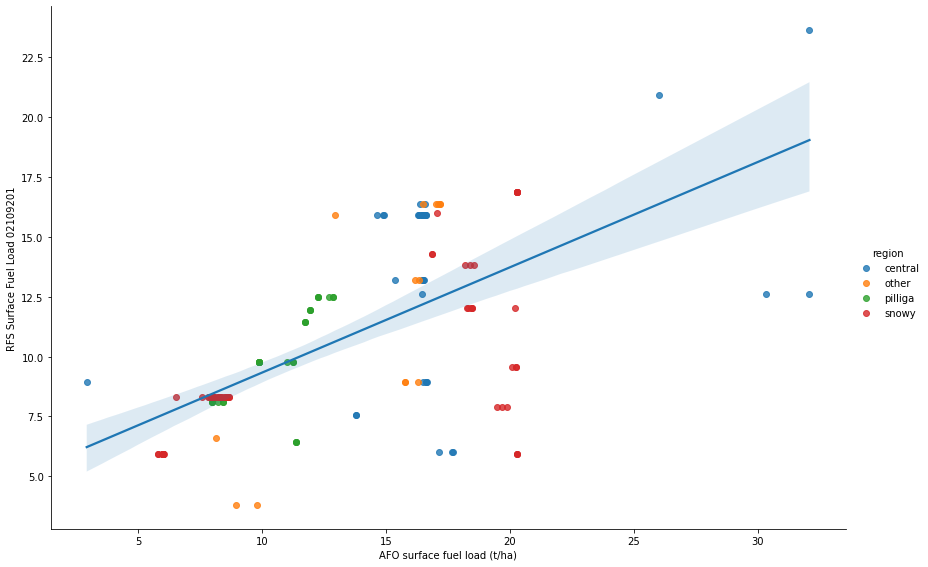

other stats:
pearson r: 0.77 	 r sq: 0.59 	 p: 0.00
central stats:
pearson r: 0.34 	 r sq: 0.11 	 p: 0.04
snowy stats:
pearson r: 0.66 	 r sq: 0.44 	 p: 0.00
pilliga stats:
pearson r: 0.67 	 r sq: 0.45 	 p: 0.00


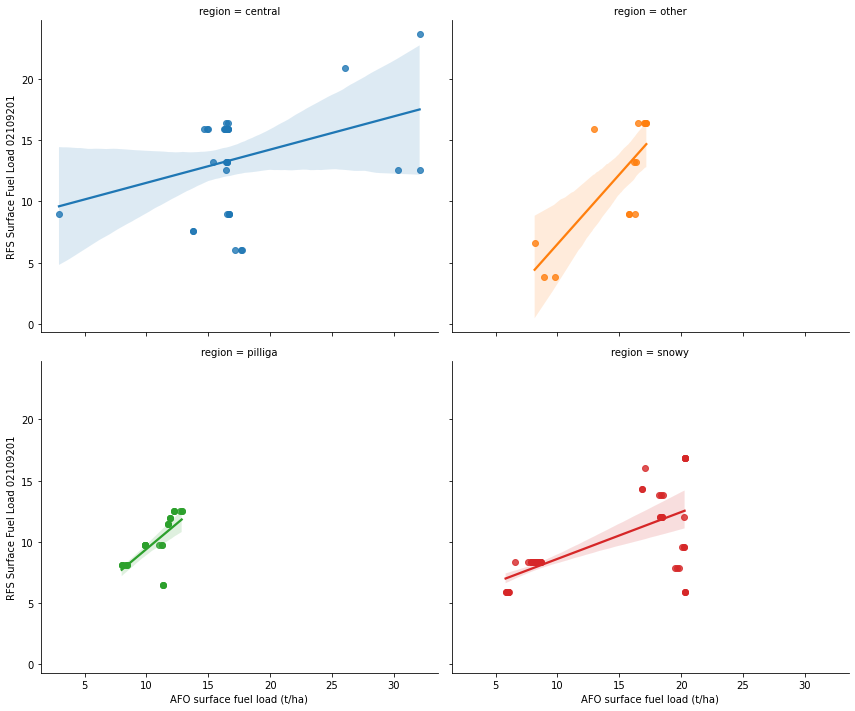

WSF stats:
pearson r: -0.26 	 r sq: 0.07 	 p: 0.30
Heath stats:
pearson r: 0.88 	 r sq: 0.78 	 p: 0.02
DSF stats:
pearson r: 0.68 	 r sq: 0.46 	 p: 0.00


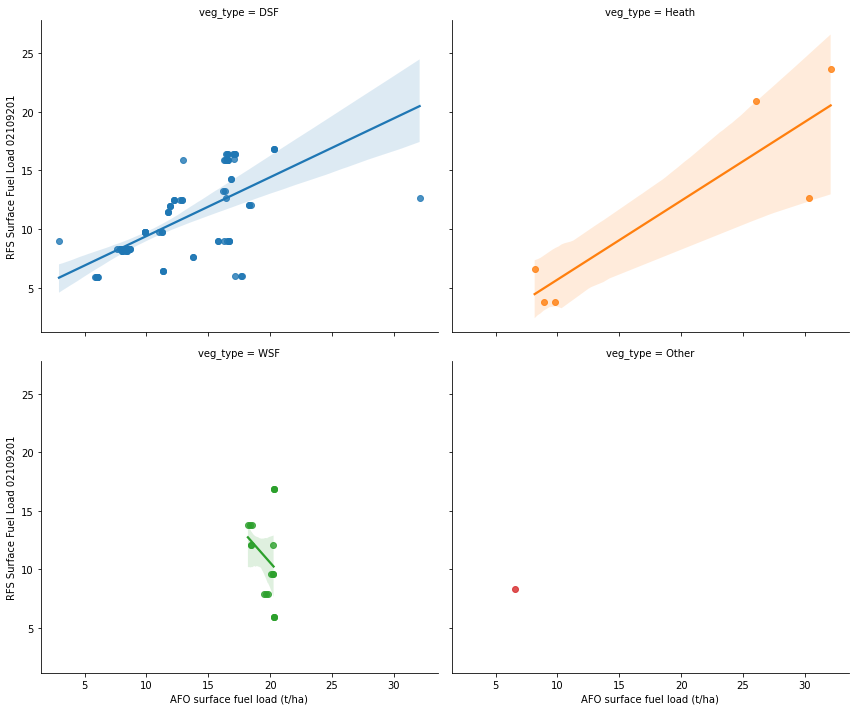

In [43]:
x = 'afo_surface'
y = 'rfs_surface'
reg_plot(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='veg_type')
plt.show()